# Inert Doublet Model (IDM)

In [1]:
from Higgs.tools.ImplementationUtils import implementMeasurement
from Higgs.tools.MeasurementValidation import *
import Higgs.signals as HS
import Higgs.bounds as HB
import pandas as pd
import numpy as np
import os
import subprocess

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rc("axes",labelsize="large")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600

import os
os.chdir('/cephfs/user/mrebuzzi/phd/HiggsTools/future_projections/')
# os.getcwd()

## Likelihood calculator

In [2]:
pred = HP.Predictions()
# bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
signals = HS.Signals('hsdataset') # load HS dataset

h = pred.addParticle(HP.NeutralScalar("h", "even"))
h.setMass(125)

coups = HP.scaledSMlikeEffCouplings(1)
HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")

chisqSM = signals(pred)


def getChisq(kappas, signals):

    for key in kappas.keys():
        if not key in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam', 'gg', "lam"]:
            continue
        else:
            setattr(coups, key, kappas[key])
        
    HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")
    return signals(pred)

## Plotting function

In [3]:
from scipy import interpolate
import scipy.stats 
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

#### Useful auxiliary statistics functions

In [4]:
def confidence_level(nsigma):
    r"""Return the confidence level corresponding to a number of sigmas,
    i.e. the probability contained in the normal distribution between $-n\sigma$
    and $+n\sigma$.

    Example: `confidence_level(1)` returns approximately 0.68."""
    return (scipy.stats.norm.cdf(nsigma)-0.5)*2

def delta_chi2(nsigma, dof):
    r"""Compute the $\Delta\chi^2$ for `dof` degrees of freedom corresponding
    to `nsigma` Gaussian standard deviations.

    Example: For `dof=2` and `nsigma=1`, the result is roughly 2.3."""
    if dof == 1:
        # that's trivial
        return nsigma**2
    chi2_ndof = scipy.stats.chi2(dof)
    cl_nsigma = confidence_level(nsigma)
    return chi2_ndof.ppf(cl_nsigma)

def chi2_prob(chi2, dof):
    r"""Compute the probability the the chi2 value is equal or larger than `chi2'
    for `dof' degrees of freedom"""
    chi2_ndof = scipy.stats.chi2(dof)
    return 1 - chi2_ndof.cdf(chi2)

def chi2_prob_sigma(chi2, dof):
    r"""Compute the probability the the chi2 value is equal or larger than `chi2'
    for `dof' degrees of freedom"""
    chisq_probability = 1 - chi2_prob(chi2, dof)
    print(chisq_probability)
    chi2_1D = scipy.stats.chi2(1)
    return np.sqrt(chi2_1D.ppf(chisq_probability))

# print(delta_chi2(nsigma=1, dof=2))
# print(chi2_prob(6.180074, 2))

# chi2_1D = scipy.stats.chi2(1)
# print(chi2_1D.ppf(0.5))
chi2_prob_sigma(6.18,2)
chi2_prob_sigma(10.423363,9)

chi2_prob_sigma(6.8, 2)
# delta_chi2(1, 9)

0.9544980455953784
0.6826894804456776
0.9666267300396739


np.float64(2.1275637558787523)

In [5]:
def read_IDM_file(df, loop_order=1, sqrt_s_ZZ=240):

    kappas = {}
    EWPOs = {}

    for fermion in ['uu', 'dd', 'ss', 'cc', 'bb', 'tt', 'ee', 'mumu', 'tautau']:
        kappas[fermion] = df['dkappaf'] + 1

    # kappas['gg'] = df['dkappaf'] + 1
    kappas['ZZ_0'] = df['effZZh1L_s0'] + df['effZZh1Lkala_s0'] + 1
    # kappas['ZZ_125'] = df['effZZh1L_s125'] + df['effZZh1Lkala_s125'] + 1
    kappas['ZZ_240'] = df['effZZh1L_s240'] + df['effZZh1Lkala_s240'] + 1
    kappas['ZZ_365'] = df['effZZh1L_s365'] + df['effZZh1Lkala_s365'] + 1
    kappas['ZZ_500'] = df['effZZh1L_s500'] + df['effZZh1Lkala_s500'] + 1
    kappas['ZZ_550'] = df['effZZh1L_s550'] + df['effZZh1Lkala_s550'] + 1

    kappas['ZZ'] = df['dghZZ1L'] + 1
    kappas['WW'] = kappas['ZZ']


    if loop_order==1:
        kappas["lam"] = df['kalam1L']

        kappas['gamgam'] = np.sqrt(df['DeltaGammagamgam1L'] + 1)
        kappas['Zgam'] = np.sqrt(df['DeltaGammaZgam1L'] + 1)

        EWPOs['Mw'] = df['MW1L']
        EWPOs['sin2thetaEff'] = df['sl1L']
        EWPOs['GammaZ'] = df['GamZ1L']

    elif loop_order==2:
        kappas["lam"] = df['kalam2LDI']

        kappas['gamgam'] = np.sqrt(df['DeltaGammagamgam2LDI'] + 1)
        kappas['Zgam'] = np.sqrt(df['DeltaGammaZgam1L'] + 1)

        EWPOs['Mw'] = df['MW2L']
        EWPOs['sin2thetaEff'] = df['sl2L']
        EWPOs['GammaZ'] = df['GamZ2L']

    else:
        raise ValueError("Wrong loop order argument!")
    
    model_pars = {}

    for par in ["mu2sq", "lam1", "lam2", "lam3", "lam4", "lam5", "mH", "mA", "mHp"]:
        model_pars[par] = df[par]

    return kappas, EWPOs, model_pars


# main plotting function
def plot_IDM_bounds(data_file, 
                    plot_dir, 
                    signals, 
                    k_lambda_exp_error=0.25, 
                    zoom=False, 
                    full=False, 
                    zoom_range_x=(2 - 3*0.25, 2 + 3*0.25),
                    zoom_range_y=(0.0, 0.005),
                    modified_central=False,
                    ndof=None,
                    chisq_max=12.,
                    plot_point=None):
    
    df = pd.read_csv(data_file + ".csv")

    df = df.replace("", np.nan)
    df = df.dropna().reset_index(drop=True)

    kappas, _ , _= read_IDM_file(df)
    
    n_pts = df.shape[0]
    chisq = np.full((n_pts,), np.nan)
    for ind in range(n_pts):
        kappas_row = {coup:kps[ind] for (coup, kps) in kappas.items()}
        chisq[ind] = getChisq(kappas_row, signals)

    if any(np.isnan(chisq)): raise ValueError('Wrong chisq!')
    
    kappas_true = {}
    for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam', 'gg', "lam"]:
        kappas_true[coup] = 1
    kappas_true["lam"] = 2

    chisq_true = getChisq(kappas_true, signals)
    if modified_central: chisq_true = getChisq(*modified_central, signals)
    chisq = chisq - chisq_true
    # y = [z if z < 12.001 else 12.001 for z in chisq]
    y = [z for z in chisq]
    df['col'] = y

    xscale = np.max(kappas['lam']) - np.min(kappas['lam'])
    yscale = np.max(kappas['ZZ'] - 1) - np.min(kappas['ZZ'] - 1)
    scale = np.array([xscale, yscale])

    mat = np.array([
        kappas['lam'].to_numpy(),
        kappas['ZZ'].to_numpy() - 1,
        df['col'].to_numpy()]).T
    
    grid_points = 300
    x = np.linspace(2 - 10*(2 - zoom_range_x[0]), 2 + 10*(zoom_range_x[1] - 2), grid_points)
    y = np.linspace(-0.02, 0.02, grid_points)
    X, Y = np.meshgrid(x, y)

    # Z = np.full((grid_points, grid_points), np.inf)
    # for i in range(grid_points):
    #     for j in range(grid_points):
    #         Z[i,j] = getChisq(x[i], 1-y[j], np.inf, signals)

    # Z = Z - chisq_true
    # Z = Z.T

    fig, ax = plt.subplots(
        figsize=(4.5, 4.),
        constrained_layout=True)

    # Rescaling colormap to avoid too-light points
    color_map = mpl.colormaps['GnBu_r']
    color_map = ListedColormap(color_map(np.linspace(0.0, 0.92, 256)))

    sc = ax.scatter(
        kappas['lam'],
        kappas['ZZ'] - 1,
        c=df['col'],
        s=0.4,
        cmap=color_map,
        # vmin=,
        vmax=chisq_max,
        rasterized=True)

    if zoom==False:
        # ax.set_xlim(np.min(kappas['lam']), np.max(kappas['lam']))
        ax.set_xlim(0, np.max(kappas['lam']))
        ax.set_ylim(np.min(kappas['ZZ'] - 1)-0.005, np.max(kappas['ZZ'] - 1))
    else:
        ax.set_xlim(*zoom_range_x)
        ax.set_ylim(*zoom_range_y)

    clb = fig.colorbar(
        sc,
        ax=ax,
        label=r"$\Delta\chi^2$",
        ticks=np.arange(0, chisq_max + 1, 1),
        pad=0,
        fraction=0.1,
        location='right',
        aspect=40,
        extend='max',
    )
    clb.ax.minorticks_on()

    if not ndof:
        if modified_central: ndof=1
        else: ndof=2
    print(ndof)
    levels_123sig = [delta_chi2(n_sigma, dof=ndof) for n_sigma in range(1, 3+1)]
    print(levels_123sig)

    # ax.contour(
    #     X,
    #     Y,
    #     Z,
    #     levels=levels_123sig,
    #     colors="black",
    #     linestyles=["-", "--", ":"],
    # )

 

    bfp_index = np.argmin(chisq)
    bfp_chisq = np.min(chisq)
    bfp = np.array([kappas['lam'][bfp_index], kappas['ZZ'][bfp_index] - 1])
    if modified_central: 
        plotted_point = list(modified_central)
        plotted_point[1] = plotted_point[1] - 1
    else: plotted_point = bfp

    ax.plot(
        *plotted_point,
        marker="*", ls="none", c="r")
    print(f"Best scan point: (k_Lamb = {bfp[0]:.10g}, (k_Z - 1) = {bfp[1]:.10g}), with chisq = {bfp_chisq:.3g}")
    print(f"Best scan point row: {bfp_index+2} out of {len(chisq)}")
    # print(f"Best scan point model parameters: muS={df["muS"][bfp_index]}, lamS={df["lamS"][bfp_index]}, lamSH={df["lamSH"][bfp_index]}")


    ax.set_xlabel(r'$\kappa_{\lambda}$')
    ax.set_ylabel(r'$\kappa_{Z} - 1$')

    if modified_central:
        chisq_SM = getChisq(1, 1, np.inf, signals) - chisq_true
        lower_text = fr"$\chi^{2}_{{\text{{SM}}}} = {{{chisq_SM:.2g}}}$ ({chi2_prob_sigma(chisq_SM, ndof):.2g}$\sigma$)"+'\n'+ \
                     f'{n_pts} Points'+'\n'+ \
                     r'Inert Doublet Model'
        
    else:
        lower_text = f'{n_pts} Points'+'\n'+ \
                     fr'$\kappa^{{\text{{Exp}}}}_{{\lambda}}(\text{{HL-LHC}})=2\pm{{{k_lambda_exp_error:.2g}}}$'+'\n'+ \
                     r'Inert Doublet Model'
    ax.text(
        0.97,
        0.05,
        lower_text,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax.transAxes,
        fontsize=8
        )

    ax.text(
        0,
        1,
        r"$\mathrm{HiggsSignals}$",
        horizontalalignment="left",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=9,
    )

    if modified_central: text_collider = "FCC-ee$_{{365}}$ Projections"
    else: text_collider = "FCC-ee$_{{365}}$ + HL-LHC Projections"
    ax.text(
        1,
        1,
        text_collider,
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=9,
    )

    
    if modified_central:
        bfp_legend_label = "Central values"+"\n"+rf"($\kappa_{{\lambda}}={modified_central[0]:.3g}$, $\kappa_{{Z}}-1={(modified_central[1]-1):.3g}$)"
    else:
        bfp_legend_label = fr"HS BFP ($\Delta\chi^2={bfp_chisq:.3g}$)"+"\n"+fr"($\kappa_{{\lambda}}={bfp[0]:.3g}$, $\kappa_{{Z}}-1={bfp[1]:.3g}$)"

    percent = r"\%" if plt.rcParams["text.usetex"] else "%"

    leg_handles = [
            Line2D([0], [0], color="k", ls="none", marker="*", c="r", 
                   label=bfp_legend_label),
            Line2D([0], [0], color="k", ls="-",  label=f"HS 68.3{percent} CL"),
            Line2D([0], [0], color="k", ls="--", label=f"HS 95.4{percent} CL"),
            Line2D([0], [0], color="k", ls=":",  label=f"HS 99.7{percent} CL"),
        ]

    legend_loc='best'
    if not plot_point is None:
        ax.plot(*plot_point, marker="*", ls="none", c="tab:orange")
        point_label = rf"Benchmark Point\n($\kappa_{{\lambda}}={plot_point[0]:.3g}$, $\kappa_{{Z}}-1={plot_point[1]:.3g}$)"
        leg_handles.append(Line2D([0], [0], color="k", ls="none", marker="*", c="tab:orange", 
                   label=point_label))
        
        # if zoom: legend_loc = 'center right'

    hsLegend = ax.legend(
        handles=leg_handles,
        loc=legend_loc,
        frameon=False,
        prop={'size': 7}
    )
    ax.add_artist(hsLegend)


    plot_name = f'IDM_results_klam_err_{k_lambda_exp_error:.2g}'
    if modified_central: plot_name = f'IDM_results_central_{modified_central[0]:.10g}_{modified_central[1]:.10g}'
    if full: plot_name = plot_name + "_full"
    if zoom: plot_name = plot_name + "_zoom"
    plt.savefig(f'{plot_dir}/{plot_name}'+".pdf")

2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.743515674, (k_Z - 1) = -0.002332812431), with chisq = 4.23
Best scan point row: 10579 out of 14048


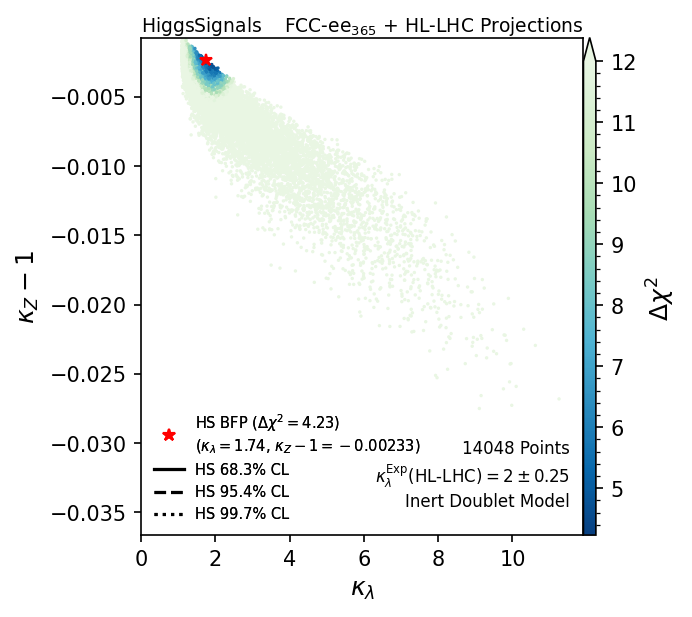

In [6]:
data_file = "data/IDM/allIDMpoints_2025-01-05"
plot_dir = "plots/IDM"
plot_IDM_bounds(data_file, plot_dir, signals)

2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.550997065, (k_Z - 1) = 0.001984595152), with chisq = 6.12
Best scan point row: 579 out of 14048


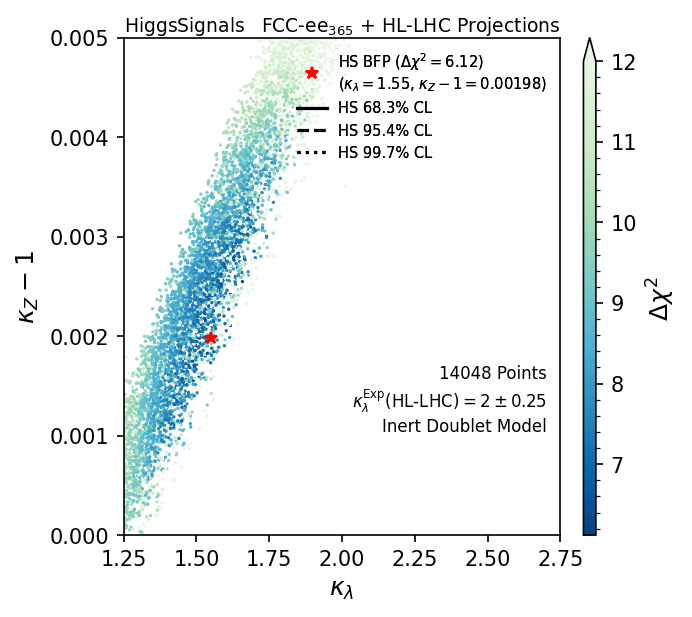

In [22]:
plot_IDM_bounds(data_file, plot_dir, signals, zoom=True)

## Tests for different HL-LHC $\kappa_{\lambda}$ pseudo-uncertainties

#### Function for modification the pseudo-uncertainty on $\kappa_{\lambda}$

In [24]:
# os.chdir("/cephfs/user/mrebuzzi/phd/HiggsTools/future_projections")

def modify_kappa_lambda_error(k_lambda_exp_error):
    
    os.system("mkdir modified_measurements")
    os.system("cp -r hsdataset/* modified_measurements/")
    os.chdir("modified_measurements/h125")
    os.system("rm EffLamHL-LHC_LHC13_LHCComb_6000.json")

    bins = {
        "effLam": {
            "coupling": "effLam",
            "obsCoupling": [2 - k_lambda_exp_error, 2, 2 + k_lambda_exp_error],
            # "obsCoupling": [2 - 50./100., 2, 2 + 50./100.],
            "process": {"channels": [[p, "WW"] for p in ("H", "vbfH")]},
        },
    }

    measFile_lam = implementMeasurement(
        "1905.03764",
        "HL-LHC Projection",
        bins,
        # corrMatExp=corrMat,
        prefix="EffLamHL-LHC",
        referenceMass=125.38,
        massResolution=0.15 * 125,  # Change!
        idSuffix=1,
        experiment="LHCComb",
        collider="LHC13",
        luminosity=6000
    )

    os.chdir("../..")


#### Modification and plotting

Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.998988458, (k_Z - 1) = 0.005156880029), with chisq = 13.9
Best scan point row: 13042 out of 14048
Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.957006266, (k_Z - 1) = 0.004994328672), with chisq = 12.6
Best scan point row: 2527 out of 14048
Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.878081001, (k_Z - 1) = 0.004368943516), with chisq = 11
Best scan point row: 11423 out of 14048
Could not detect experiment
Looks good. Saving this to 

0

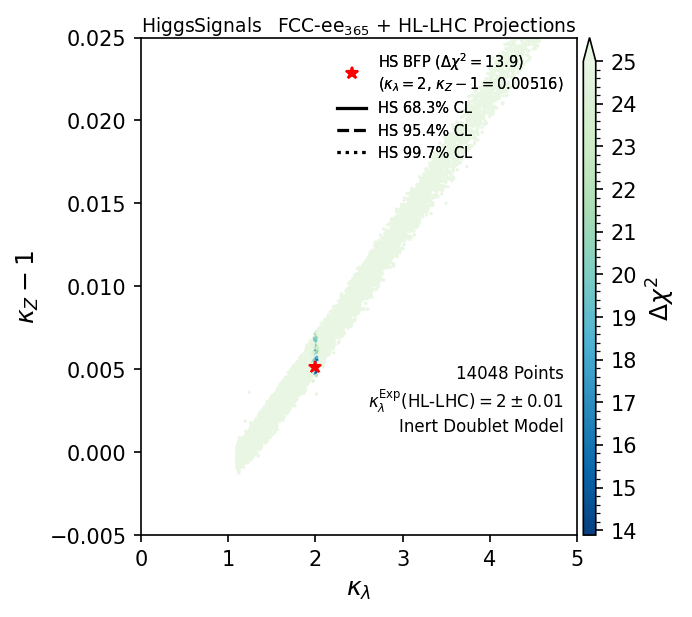

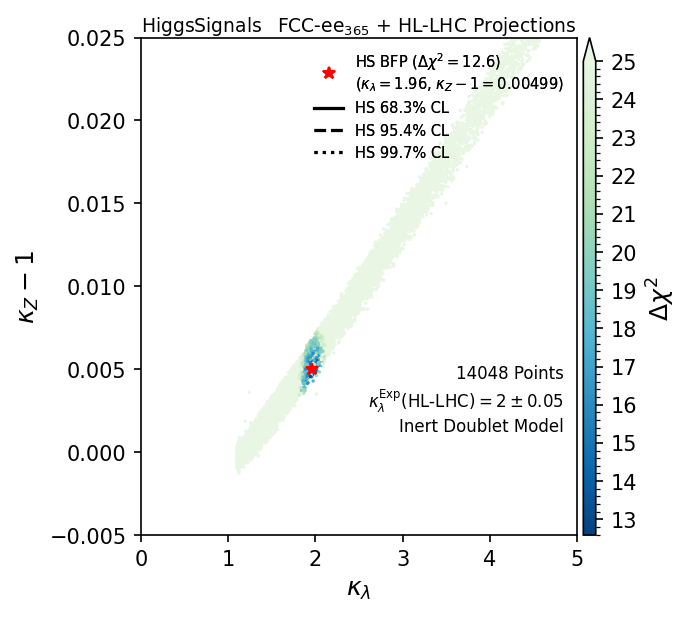

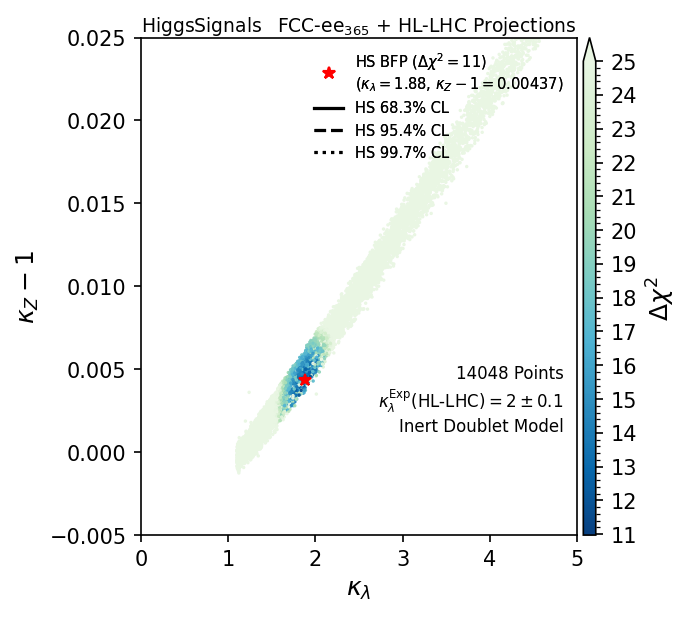

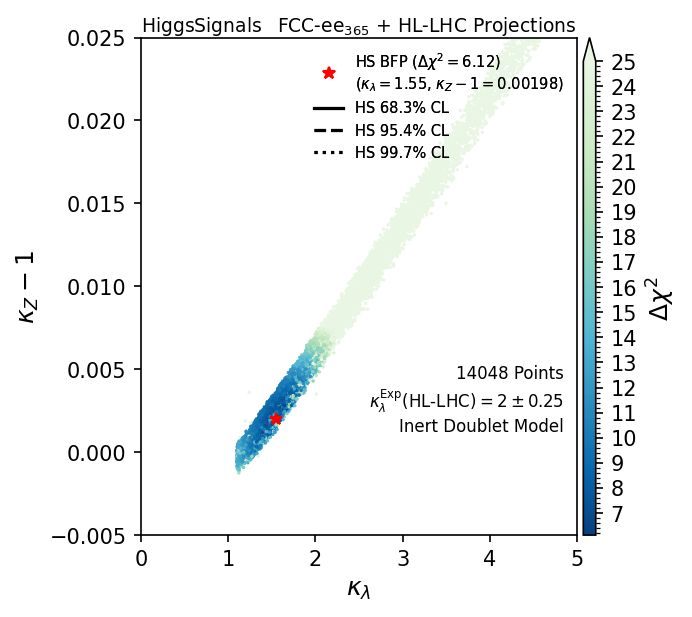

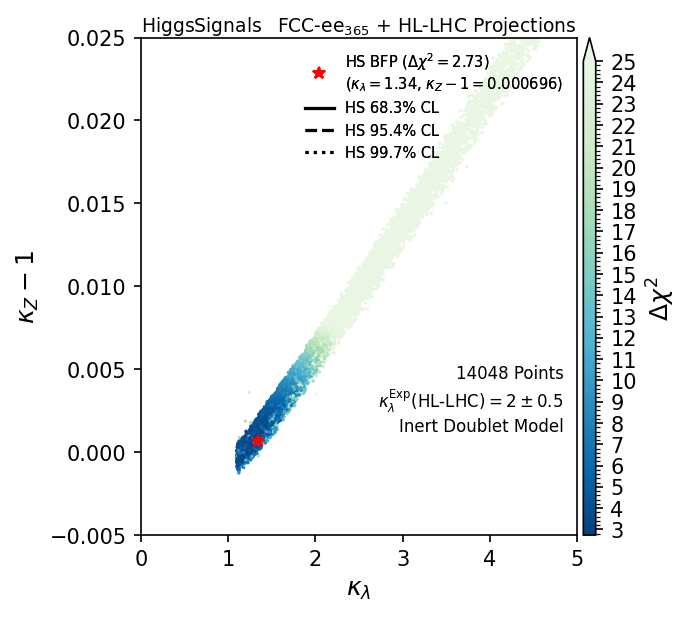

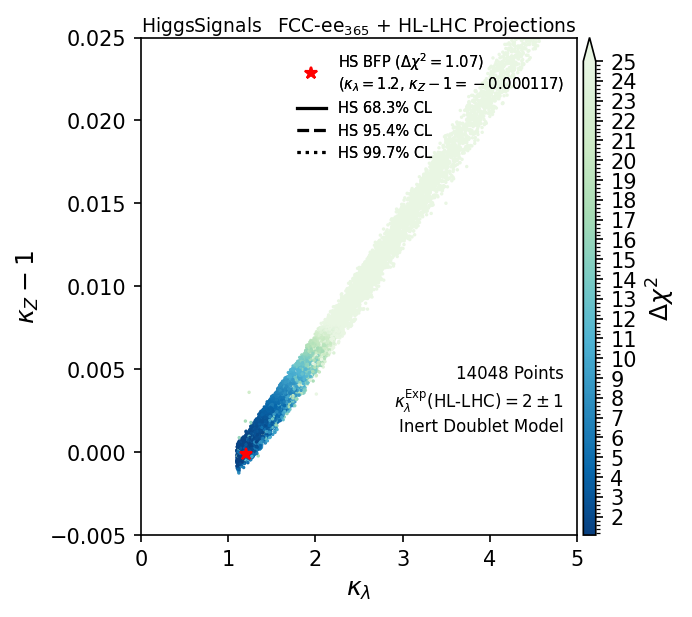

In [ ]:
data_file = "data/IDM/allIDMpoints_2025-01-05"
plot_dir = "plots"
for k_lambda_exp_error in [0.01, 0.05, 0.1, 0.25, 0.5, 1]:
# for k_lambda_exp_error in [0.5]:
    pred = HP.Predictions()
    modify_kappa_lambda_error(k_lambda_exp_error)

    # bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
    signals_mod = HS.Signals('modified_measurements') # load HS dataset

    h = pred.addParticle(HP.NeutralScalar("h", "even"))
    h.setMass(125)

    # coups = HP.scaledSMlikeEffCouplings(1)
    # HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")
    plot_IDM_bounds(data_file, plot_dir, signals_mod, k_lambda_exp_error=k_lambda_exp_error, zoom=True,
                    zoom_range_x=(0, 5), zoom_range_y=(-0.005, 0.025), chisq_max=25)

    os.system("rm -rf modified_measurements")
    
os.system("rm -rf modified_measurements")


In [ ]:
data_file = "data/IDM/allIDMpoints_2025-01-05"
plot_dir = "plots"
for k_lambda_exp_error in [0.01, 0.05, 0.1, 0.25, 0.5, 1]:
# for k_lambda_exp_error in [0.5]:
    pred = HP.Predictions()
    modify_kappa_lambda_error(k_lambda_exp_error)

    # bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
    signals_mod = HS.Signals('modified_measurements') # load HS dataset

    h = pred.addParticle(HP.NeutralScalar("h", "even"))
    h.setMass(125)

    # coups = HP.scaledSMlikeEffCouplings(1)
    # HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")
    plot_IDM_bounds(data_file, plot_dir, signals_mod, k_lambda_exp_error=k_lambda_exp_error, zoom=True,
                        zoom_range_x=(2 - 3*k_lambda_exp_error, 2 + 3*k_lambda_exp_error))
    
os.system("rm -rf modified_measurements")

# New FCC-ee projections with obtained points

We take the kappa values obtained from the scans and use them as central values for the future projections for FCC-ee measurements, without any direct $\kappa_{\lambda}$ constraint from HL-LHC/ILC

#### Minimizing $\left|\frac{(\kappa_Z^{365}-\kappa_Z^{240})}{(\kappa_Z^{240}-1)}\right|$

In [ ]:
full=True
data_file="data/IDM/allIDMpoints_2025-01-14"
min_lambda = 1.5
max_delta_KZ = 0.01
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna().reset_index(drop=True)
old_df_indices = df.iloc[:, 0].to_numpy()

kappas, EWPOs, model_pars = read_IDM_file(df)

n_pts = df.shape[0]
chisq = np.full((n_pts,), np.nan)
delta_kZ_240_365 = np.full((n_pts,), np.nan)
for ind in range(n_pts):
    kappas_row = {coup:kps[ind] for (coup, kps) in kappas.items()}
    chisq[ind] = getChisq(kappas_row, signals)
    # delta_kZ_240_365[ind] = np.abs(kappas_row['ZZ_240']**2/kappas_row['ZZ_365']**2 - 1)
    delta_kZ_240_365[ind] = np.abs((kappas_row['ZZ_365'] - kappas_row['ZZ_240'])/(kappas_row['ZZ_240'] - 1))

if any(np.isnan(chisq)): raise ValueError('Wrong chisq!')
    
for ind, (lam, kZ) in enumerate(zip(kappas['lam'], kappas['ZZ'])):
    # if lam < min_lambda: chisq[ind]=1e30
    if lam < min_lambda or np.abs(kZ-1) > max_delta_KZ: delta_kZ_240_365[ind]=1e30

# bfp_index = np.argmin(chisq)
bfp_index = np.argmin(delta_kZ_240_365)
# bfp_chisq = np.min(chisq)
bfp_chisq = chisq[bfp_index]
bfp_kappas = {coup:kps[bfp_index] for (coup, kps) in kappas.items()}
bfp_EWPOs = {obs_name:obs_value[bfp_index] for (obs_name, obs_value) in EWPOs.items()}

for coup, kaps in bfp_kappas.items():
    print(f"kappas['{coup}'] = {kaps}")

print(f"abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = {np.abs((bfp_kappas['ZZ_365'] - bfp_kappas['ZZ_240'])/(bfp_kappas['ZZ_240'] - 1))}")

for obs_name, obs_value in bfp_EWPOs.items():
    print(f"{obs_name} = {obs_value}")

print(f"Best scan point row: {bfp_index+2} out of {len(chisq)+2}")

kappas['uu'] = 0.9922066823296164
kappas['dd'] = 0.9922066823296164
kappas['ss'] = 0.9922066823296164
kappas['cc'] = 0.9922066823296164
kappas['bb'] = 0.9922066823296164
kappas['tt'] = 0.9922066823296164
kappas['ee'] = 0.9922066823296164
kappas['mumu'] = 0.9922066823296164
kappas['tautau'] = 0.9922066823296164
kappas['ZZ_0'] = 0.9995440099827713
kappas['ZZ_125'] = 1.0003009582425018
kappas['ZZ_240'] = 1.0033105386486372
kappas['ZZ_365'] = 1.002154474320703
kappas['ZZ_500'] = 1.004902605630624
kappas['ZZ_550'] = 1.006775403556579
kappas['ZZ'] = 0.9952035995782093
kappas['WW'] = 0.9952035995782093
kappas['lam'] = 1.5027312712751126
kappas['gamgam'] = 0.9511673913600965
kappas['Zgam'] = 0.9818672684619811
abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = 0.34920731960345985
Mw = 80.35935286139284
sin2thetaEff = 0.2314822952404524
GammaZ = 2.494346193565529
Best scan point row: 7313 out of 14050


2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.743515674, (k_Z - 1) = -0.002332812431), with chisq = 4.23
Best scan point row: 10579 out of 14048


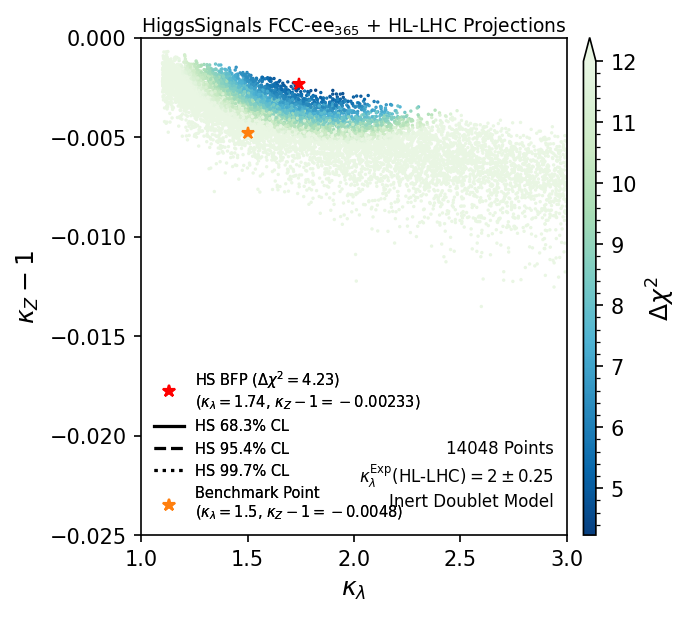

In [34]:
plot_dir = "plots/IDM"
plot_IDM_bounds(data_file, plot_dir, signals, zoom=True, 
                plot_point=(bfp_kappas['lam'], bfp_kappas['ZZ']-1),
                zoom_range_x=(1.0, 3.0), zoom_range_y=(-0.025, 0.0))

In [ ]:
full=True
data_file="data/IDM/allIDMpoints_2025-01-14"
min_lambda = 1.5
max_delta_SingleHiggs = 0.01
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna().reset_index(drop=True)
old_df_indices = df.iloc[:, 0].to_numpy()

kappas, EWPOs, model_pars = read_IDM_file(df)

def print_to_file(message, file):
    print(message)
    print(message, file=file)

def find_benchmark(BP,
                   BP_output_file,
                   min_lambda=-1., 
                   max_lambda=np.inf,
                   max_delta_SingleHiggs=np.inf, 
                   max_delta_gamgam=np.inf,
                   absolute_delta_kz=False,
                   maximize_delta_kz=False,
                   ):

    print_to_file(f"\nif BP == \"{BP}\":", file=BP_output_file)
    print_to_file(f"\n    # Finding benchmark point {BP}, with constraints:", file=BP_output_file)
    print_to_file(f"    # min_lambda = {min_lambda}", file=BP_output_file)
    print_to_file(f"    # max_lambda = {max_lambda}", file=BP_output_file)
    print_to_file(f"    # max_delta_SingleHiggs = {max_delta_SingleHiggs}", file=BP_output_file)
    print_to_file(f"    # max_delta_gamgam = {max_delta_gamgam}", file=BP_output_file)
    print_to_file(f"    # absolute_delta_kz = {absolute_delta_kz}", file=BP_output_file)
    print_to_file(f"    # maximize_delta_kz = {maximize_delta_kz}\n", file=BP_output_file)

    n_pts = df.shape[0]
    chisq = np.full((n_pts,), np.nan)
    delta_kZ_240_365 = np.full((n_pts,), np.nan)
    for ind in range(n_pts):
        kappas_row = {coup:kps[ind] for (coup, kps) in kappas.items()}
        chisq[ind] = getChisq(kappas_row, signals)

        if not absolute_delta_kz:
            delta_kZ_240_365[ind] = np.abs((kappas_row['ZZ_365'] - kappas_row['ZZ_240'])/(kappas_row['ZZ_240'] - 1))
        else:
            delta_kZ_240_365[ind] = np.abs(kappas_row['ZZ_365'] - kappas_row['ZZ_240'])
        
    if any(np.isnan(chisq)): raise ValueError('Wrong chisq!')
        
    for ind, (lam, kZ, kZgam, kgamgam, kfermion) in enumerate(zip(kappas['lam'], kappas['ZZ'], kappas['Zgam'], kappas['gamgam'], kappas['bb'])):
        if (lam < min_lambda
            or lam > max_lambda 
            or np.abs(kZ-1) > max_delta_SingleHiggs
            # or np.abs(kZgam-1) > max_delta_SingleHiggs
            or np.abs(kgamgam-1) > max_delta_gamgam
            or np.abs(kfermion-1) > max_delta_SingleHiggs
        ): 
            if not maximize_delta_kz:
                delta_kZ_240_365[ind] = np.inf
            else:
                delta_kZ_240_365[ind] = -1.

    if not maximize_delta_kz:
        bfp_index = np.argmin(delta_kZ_240_365)
    else:
        bfp_index = np.argmax(delta_kZ_240_365)
    bfp_chisq = chisq[bfp_index]
    bfp_kappas = {coup:kps[bfp_index] for (coup, kps) in kappas.items()}
    bfp_EWPOs = {obs_name:obs_value[bfp_index] for (obs_name, obs_value) in EWPOs.items()}

    for coup, kaps in bfp_kappas.items():
        print_to_file(f"    kappas['{coup}'] = {kaps}", file=BP_output_file)

    print_to_file(f"    # abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = {np.abs((bfp_kappas['ZZ_365'] - bfp_kappas['ZZ_240'])/(bfp_kappas['ZZ_240'] - 1))}", file=BP_output_file)
    print_to_file(f"    # abs(kappas['ZZ_365'] - kappas['ZZ_240']) = {np.abs(bfp_kappas['ZZ_365'] - bfp_kappas['ZZ_240'])}", file=BP_output_file)

    for obs_name, obs_value in bfp_EWPOs.items():
        print_to_file(f"    {obs_name} = {obs_value}", file=BP_output_file)

    print_to_file(f"    # Best scan point row: {old_df_indices[bfp_index]+2} out of {len(old_df_indices)+2}", file=BP_output_file)

    if delta_kZ_240_365[bfp_index] == np.inf: 
        raise ValueError("Could not find point satisfying the constraints!")


output_dir = "./scan_output/IDM_scan_output"
subprocess.run(["mkdir", "-p", output_dir])

BP_filename = f"{output_dir}/Benchmark_Points.txt"
with open(BP_filename, "w") as BP_output_file:

    BPs = [{'BP_name' : f'BP_{i}', 
            'min_lambda': -1., 
            'max_lambda': np.inf, 
            'max_delta_SingleHiggs': np.inf,
            'max_delta_gamgam': np.inf,
            'absolute_delta_kz': False,
            'maximize_delta_kz': False,
            } for i in range(8)]


    BPs[0]['min_lambda'] = 1.5;  BPs[0]['max_delta_SingleHiggs'] = 5e-3 ;  BPs[0]['max_delta_gamgam'] = 1.5e-2
    BPs[1]['min_lambda'] = 1.5;  BPs[1]['max_delta_SingleHiggs'] = 5e-3 ;  BPs[1]['max_delta_gamgam'] = 1.5e-2 ;  BPs[1]['absolute_delta_kz'] = True

    # BPs[2]['min_lambda'] = 1.8;  BPs[2]['max_delta_SingleHiggs'] = 5e-3 ;  BPs[2]['max_delta_gamgam'] = 1.5e-2
    # BPs[3]['min_lambda'] = 1.8;  BPs[3]['max_delta_SingleHiggs'] = 5e-3 ;  BPs[3]['max_delta_gamgam'] = 1.5e-2 ;  BPs[3]['absolute_delta_kz'] = True

    BPs[2]['min_lambda'] = 2.0;  BPs[2]['max_delta_SingleHiggs'] = BPs[2]['max_delta_gamgam'] = 5e-2 ; 
    BPs[3]['min_lambda'] = 2.0;  BPs[3]['max_delta_SingleHiggs'] = BPs[3]['max_delta_gamgam'] = 5e-2 ;  BPs[3]['absolute_delta_kz'] = True

    BPs[4]['min_lambda'] = 1.5;  BPs[4]['max_delta_SingleHiggs'] = BPs[4]['max_delta_gamgam'] = 5e-2 ; 
    BPs[5]['min_lambda'] = 1.5;  BPs[5]['max_delta_SingleHiggs'] = BPs[5]['max_delta_gamgam'] = 5e-2 ;  BPs[5]['absolute_delta_kz'] = True

    BPs[6]['max_lambda'] = 1.21; BPs[6]['max_delta_SingleHiggs'] = 1e-2 ; BPs[6]['max_delta_gamgam'] = 2e-2 ;  BPs[6]['maximize_delta_kz'] = True
    BPs[7]['max_lambda'] = 1.21; BPs[7]['max_delta_SingleHiggs'] = 1e-2 ; BPs[7]['max_delta_gamgam'] = 2e-2 ;  BPs[7]['maximize_delta_kz'] = True ; BPs[7]['absolute_delta_kz'] = True

    for BP in BPs:
        find_benchmark(BP['BP_name'],
                       BP_output_file,
                       BP['min_lambda'], 
                       BP['max_lambda'],
                       BP['max_delta_SingleHiggs'], 
                       BP['max_delta_gamgam'], 
                       BP['absolute_delta_kz'],
                       BP['maximize_delta_kz'])


if BP == "BP_0":

    # Finding benchmark point BP_0, with constraints:
    # min_lambda = 1.5
    # max_lambda = inf
    # max_delta_SingleHiggs = 0.005
    # max_delta_gamgam = 0.015
    # absolute_delta_kz = False
    # maximize_delta_kz = False



KeyboardInterrupt: 

### Plot EffZZH[240] vs EffZZH[365]

In [7]:
def generate_plot(fig,
                  ax,
                  kappas,
                  signals, 
                  plot_colorbar,
                  zoom=False, 
                  zoom_range_x=(2 - 3*0.25, 2 + 3*0.25),
                  zoom_range_y=(0.0, 0.005),
                  plot_points=None,
                  BR_constraints=None,
                  ):
    
    color = np.array(kappas['lam'], dtype=complex).real

    if BR_constraints is None:
        x_data = kappas['ZZ_365'].to_numpy() - 1
        y_data = kappas['ZZ_240'].to_numpy() - 1
    else:
        x_data = kappas['ZZ_365'] - 1
        y_data = kappas['ZZ_240'] - 1

    color_map = mpl.colormaps['tab20c']

    sc = ax.scatter(
        x_data,
        y_data,
        c=color,
        s=0.4,
        vmin=1.,
        vmax=12.,
        cmap=color_map,
        rasterized=True)

    if zoom==True:
        ax.set_xlim(*zoom_range_x)
        ax.set_ylim(*zoom_range_y)

    # Check if colorbar has been plotted already
    if plot_colorbar:
        clb = fig.colorbar(
            sc,
            ax=ax,
            label=r"$\kappa_\lambda$",
            pad=0,
            fraction=0.1,
            location='right',
            aspect=40,
            extend='max',
        )
        clb.ax.minorticks_on()

        plot_colorbar = False

    return plot_colorbar

def plot_EffZZH_240_vs_365(data_file, 
                           plot_dir, 
                           signals, 
                           k_lambda_exp_error=0.25, 
                           zoom=False, 
                           zoom_range_x=(2 - 3*0.25, 2 + 3*0.25),
                           zoom_range_y=(0.0, 0.005),
                           modified_central=False,
                           ndof=None,
                           chisq_max=12.,
                           plot_points=None,
                           point_colors=None,
                           point_leg_columns=2,
                           point_leg_size=6,
                           point_marker_size=10,
                           markeredgewidth=0.5,
                           point_markers="*",
                           BR_constraints=None,
                           plot_self_consistent_curve=False,
                           plot_name_suffix="",
                           no_model_text=False,
                           upper_right_text=None,
                           ):
    

    fig, ax = plt.subplots(
                figsize=(4.5, 4.),
                constrained_layout=True)

    plot_colorbar = True

    if isinstance(data_file, str):
        print(f"Processing data file: {data_file}")
        df = pd.read_csv(data_file + ".csv")
        df = df.replace("", np.nan)
        df = df.dropna().reset_index(drop=True)
        n_pts = df.shape[0]
        n_pts_total = n_pts

        kappas, _ , _ = read_IDM_file(df)

        if not BR_constraints is None:
            satisfy_BR_constraint = [True for i in range(n_pts)]
            for i in range(n_pts):
                for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam']:
                    if np.abs(kappas[coup][i] - 1.) > BR_constraints:
                        satisfy_BR_constraint[i] = False

            for coup in kappas.keys():
                kappas[coup] = np.array(kappas[coup][satisfy_BR_constraint])

            n_pts_BR_constraint = len(kappas['ZZ'])
            print(f"Number of points satisfying the {BR_constraints*100:.3g}% SM constraint on the single higgs couplings: {n_pts_BR_constraint} / {n_pts}")

            n_pts_BR_constraint_total =  n_pts_BR_constraint

        generate_plot(fig=fig,
                      ax=ax,
                      kappas=kappas,
                      signals=signals, 
                      zoom=zoom, 
                      zoom_range_x=zoom_range_x,
                      zoom_range_y=zoom_range_y,
                      plot_points=plot_points,
                      BR_constraints=BR_constraints,
                      plot_colorbar=plot_colorbar,
                      )

    elif isinstance(data_file, list) and all(isinstance(item, str) for item in data_file):
        print(f"Processing data files: {data_file}")
        n_pts = 0
        n_pts_total = 0
        if not BR_constraints is None:
            n_pts_BR_constraint_total = 0

        for file in data_file:
            df = pd.read_csv(file + ".csv")
            df = df.replace("", np.nan)
            df = df.dropna().reset_index(drop=True)
            n_pts = df.shape[0]
            n_pts_total = n_pts_total + n_pts

            kappas, _, _ = read_IDM_file(df)

            if not BR_constraints is None:
                satisfy_BR_constraint = [True for i in range(n_pts)]
                for i in range(n_pts):
                    for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam']:
                        if np.abs(kappas[coup][i] - 1.) > BR_constraints:
                            satisfy_BR_constraint[i] = False

                for coup in kappas.keys():
                    kappas[coup] = np.array(kappas[coup][satisfy_BR_constraint])

                n_pts_BR_constraint = len(kappas['ZZ'])
                print(f"Number of points satisfying the {BR_constraints*100:.3g}% SM constraint on the single higgs couplings: {n_pts_BR_constraint} / {n_pts}")

                n_pts_BR_constraint_total = n_pts_BR_constraint_total + n_pts_BR_constraint

            plot_colorbar = generate_plot(fig=fig,
                                          ax=ax,
                                          kappas=kappas,
                                          signals=signals, 
                                          zoom=zoom, 
                                          zoom_range_x=zoom_range_x,
                                          zoom_range_y=zoom_range_y,
                                          plot_points=plot_points,
                                          BR_constraints=BR_constraints,
                                          plot_colorbar=plot_colorbar
                                          )

    else:
        raise ValueError("Input must be a string or a list of strings.")

    
    # if not BR_constraints is None:

    #     satisfy_BR_constraint = [True for i in range(n_pts)]
    #     for i in range(n_pts):
    #         for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam']:
    #             if np.abs(kappas[coup][i] - 1.) > BR_constraints:
    #                 satisfy_BR_constraint[i] = False

    #     for coup in kappas.keys():
    #         kappas[coup] = np.array(kappas[coup][satisfy_BR_constraint])

    #     n_pts_BR_constraint = len(kappas['ZZ'])
    #     print(f"Number of points satisfying the {BR_constraints*100:.3g}% SM constraint on the single higgs couplings: {n_pts_BR_constraint} / {n_pts}")

    #     n_pts = n_pts_BR_constraint
    
    # color = np.array(kappas['lam'], dtype=complex).real

    # if BR_constraints is None:
    #     x_data = kappas['ZZ_365'].to_numpy() - 1
    #     y_data = kappas['ZZ_240'].to_numpy() - 1
    # else:
    #     x_data = kappas['ZZ_365'] - 1
    #     y_data = kappas['ZZ_240'] - 1

    # color_map = mpl.colormaps['tab20c']

    # sc = ax.scatter(
    #     x_data,
    #     y_data,
    #     c=color,
    #     s=0.4,
    #     cmap=color_map,
    #     rasterized=True)

    # if zoom==True:
    #     ax.set_xlim(*zoom_range_x)
    #     ax.set_ylim(*zoom_range_y)

    # clb = fig.colorbar(
    #     sc,
    #     ax=ax,
    #     label=r"$\kappa_\lambda$",
    #     pad=0,
    #     fraction=0.1,
    #     location='right',
    #     aspect=40,
    #     extend='max',
    # )
    # clb.ax.minorticks_on()

    ax.set_xlabel(r'$\kappa_{Zh}^{365} - 1$')
    ax.set_ylabel(r'$\kappa_{Zh}^{240} - 1$')


    lower_text = r'Inert Doublet Model'

    if BR_constraints:
        lower_text = lower_text + f"\n{BR_constraints*100:.3g}% SM constraints"
        lower_text = lower_text + f"\n{n_pts_BR_constraint_total} / {n_pts_total} Points"

    else:
        lower_text = lower_text + f'\n{n_pts_total} Points'+'\n'
    
    if not no_model_text:
        ax.text(
            0.97,
            0.05,
            lower_text,
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax.transAxes,
            fontsize=8
            )

    # ax.text(
    #     0,
    #     1,
    #     r"$\mathrm{HiggsSignals}$",
    #     horizontalalignment="left",
    #     verticalalignment="bottom",
    #     transform=ax.transAxes,
    #     fontsize=9,
    # )

    if modified_central: text_collider = "FCC-ee$_{{365}}$ Projections"
    else: text_collider = "FCC-ee$_{{365}}$ + HL-LHC Projections"
    if not upper_right_text is None:
        text_collider = upper_right_text
    ax.text(
        1,
        1,
        text_collider,
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=9,
    )


    if not plot_self_consistent_curve is None:

        
        legend_loc = "best"
        colors = mpl.colormaps['hsv']


        if isinstance(plot_self_consistent_curve, str):

            leg_handles = []

            lambdas=[]
            k_ZH_240 = {}
            k_ZH_365 = {}

            if plot_self_consistent_curve=='CH':
                file_name = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits/comparison_plots/k_ZH_240_365_predictions.txt"
            elif plot_self_consistent_curve=='CHbox':
                file_name = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits_CHbox/comparison_plots/k_ZH_240_365_predictions.txt"
            else:
                raise ValueError("\'plot_self_consistent_curve\' must be a valid Wilson coefficient!")

            with open(file_name, "r") as self_consistent_results_file:
                lines = self_consistent_results_file.readlines()
                for n, line in enumerate(lines):
                    columns = line.split()

                    if plot_self_consistent_curve=='CH':
                        lmbd = int(columns[0])
                    if plot_self_consistent_curve=='CHbox':
                        lmbd = float(columns[0])

                    lambdas.append(lmbd)
                    if columns[1].startswith("eeZH_FCCee240"):
                        k_ZH_240[lmbd] = np.sqrt(float(columns[2]))
                    elif columns[1].startswith("eeZH_FCCee365"):
                        k_ZH_365[lmbd] = np.sqrt(float(columns[2]))

            print(lambdas)
            print(k_ZH_240)
            print(k_ZH_365)

            lambdas_unique = [lmbd for i, lmbd in enumerate(lambdas) if i%2==0 ]
            
            color = list(colors(np.linspace(0.001, 0.9, len(lambdas_unique))[::-1]))

            ax.plot([(k_ZH_365[lmbd]-1) for lmbd in lambdas_unique],
                    [(k_ZH_240[lmbd]-1) for lmbd in lambdas_unique],
            )

            for i, lmbd in enumerate(lambdas_unique):
                ax.plot((k_ZH_365[lmbd]-1), (k_ZH_240[lmbd]-1), marker="*", ls="none", c=color[i], markersize=10, markeredgecolor='white', markeredgewidth=0.5)

                point_label = rf"$\kappa_\lambda$ = {lmbd}"
                leg_handles.append(Line2D([0], [0], color="k", ls="none", marker="*", c=color[i], markersize=10, markeredgecolor='white', markeredgewidth=0.5, label=point_label))

            hsLegend = ax.legend(
                        handles=leg_handles,
                        loc=legend_loc,
                        frameon=False,
                        prop={'size': 6},
                        ncol=2,
                    )
            ax.add_artist(hsLegend)

        elif isinstance(plot_self_consistent_curve, list) and all(isinstance(item, str) for item in plot_self_consistent_curve):
            if plot_self_consistent_curve==["CH", "CHbox"]:

                lambdas = {}
                k_ZH_240 = {}
                k_ZH_365 = {}
                for WC in plot_self_consistent_curve:

                    leg_handles = []
                    lambdas[WC]=[]
                    k_ZH_240[WC] = {}
                    k_ZH_365[WC] = {}

                    if WC=='CH':
                        file_name = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits/comparison_plots/k_ZH_240_365_predictions.txt"
                        legend_loc='upper left'
                        marker="*"
                        color_line="tab:blue"
                        label_line=r'$C_{H}$'
                        markersize=10
                    elif WC=='CHbox':
                        file_name = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits_CHbox/comparison_plots/k_ZH_240_365_predictions.txt"
                        legend_loc='lower right'
                        marker="s"
                        color_line="tab:orange"
                        label_line=r'$C_{H\boxdot}$'
                        markersize=5


                    with open(file_name, "r") as self_consistent_results_file:
                        lines = self_consistent_results_file.readlines()
                        for n, line in enumerate(lines):
                            columns = line.split()

                            if WC=='CH':
                                lmbd = int(columns[0])
                            if WC=='CHbox':
                                lmbd = float(columns[0])

                            lambdas[WC].append(lmbd)
                            if columns[1].startswith("eeZH_FCCee240"):
                                k_ZH_240[WC][lmbd] = np.sqrt(float(columns[2]))
                            elif columns[1].startswith("eeZH_FCCee365"):
                                k_ZH_365[WC][lmbd] = np.sqrt(float(columns[2]))

                    print(lambdas[WC])
                    print(k_ZH_240[WC])
                    print(k_ZH_365[WC])

                    lambdas_unique = [lmbd for i, lmbd in enumerate(lambdas[WC]) if i%2==0 ]
                    
                    color = list(colors(np.linspace(0.001, 0.9, len(lambdas_unique))[::-1]))

                    ax.plot([(k_ZH_365[WC][lmbd]-1) for lmbd in lambdas_unique],
                            [(k_ZH_240[WC][lmbd]-1) for lmbd in lambdas_unique],
                            color=color_line,
                    )
                    leg_handles.append(Line2D([0], [0], color="k", ls="-", c=color_line, label=label_line))

                    for i, lmbd in enumerate(lambdas_unique):
                        ax.plot((k_ZH_365[WC][lmbd]-1), (k_ZH_240[WC][lmbd]-1), marker=marker, ls="none", c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5)

                        point_label = rf"$\kappa_\lambda$ = {lmbd}"
                        leg_handles.append(Line2D([0], [0], color="k", ls="none", marker=marker, c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5, label=point_label))

                    hsLegend = ax.legend(
                        handles=leg_handles,
                        loc=legend_loc,
                        frameon=False,
                        prop={'size': 6},
                        ncol=2,
                    )
                    ax.add_artist(hsLegend)
        


    if not plot_points is None:

        leg_handles = []
        # legend_loc='best'
        legend_loc='upper left'

        # color = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:cyan"]
        color = ["tab:orange", "tab:blue", ]

        # color = []
        
        colors = mpl.colormaps['tab20b']
        color = color + list(colors(np.linspace(0.001, 0.999, len(plot_points)+1)[::-1]))

        if not point_colors is None:
            if point_colors == "lambdas":
                color = np.array(kappas['lam'], dtype=complex).real
                color_map = mpl.colormaps['tab20c']
                norm = Normalize(vmin=1.0, vmax=12.)
                color = [ color_map(norm(pt[3])) for pt in plot_points]
            else:
                color = point_colors


        for arg in [point_marker_size, markeredgewidth, point_markers]:
            if isinstance(arg, list) and len(arg) != len(plot_points):
                raise ValueError(f"Length of {arg} must be equal to the number of points in plot_points or a single integer/float.")

        if isinstance(point_marker_size, (int, float)):
            point_marker_size = [point_marker_size for i in range(len(plot_points))]
        if isinstance(markeredgewidth, (int, float)):
            markeredgewidth = [markeredgewidth for i in range(len(plot_points))]
        if isinstance(point_markers, str):
            point_markers = [point_markers for i in range(len(plot_points))]

            
        for i, plot_point in enumerate(plot_points):
            ax.plot(*(plot_point[:2]), marker=point_markers[i], ls="none", c=color[i], markersize=point_marker_size[i], markeredgecolor='white', markeredgewidth=markeredgewidth[i])
            point_label = f"{plot_point[2]}"
            # point_label = f"{plot_point[2]}\n($\kappa_{{\lambda}}={plot_point[0]:.3g}$, $\kappa_{{Z}}-1={plot_point[1]:.3g}$)"
            leg_handles.append(Line2D([0], [0], color="k", ls="none", marker=point_markers[i], c=color[i], markersize=point_marker_size[i], markeredgecolor='white', markeredgewidth=markeredgewidth[i], label=point_label))
            
            # if zoom: legend_loc = 'center right'

        hsLegend = ax.legend(
            handles=leg_handles,
            loc=legend_loc,
            frameon=False,
            prop={'size': point_leg_size},
            ncol=point_leg_columns,
        )
        ax.add_artist(hsLegend)


    if BR_constraints:
        plot_name = f'IDM_results_EffZZH_240_vs_365_{BR_constraints:.3g}_SM_constraints'
    else:
        plot_name = f'IDM_results_EffZZH_240_vs_365'

    if not (plot_points is None):
        plot_name = plot_name + "_BPs"
    # if modified_central: plot_name = f'IDM_results_central_{modified_central[0]:.10g}_{modified_central[1]:.10g}'
    if zoom: plot_name = plot_name + "_zoom"
    # plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+".pdf")

    return fig, ax

Processing data file: data/IDM/allIDMpoints_2025-01-14


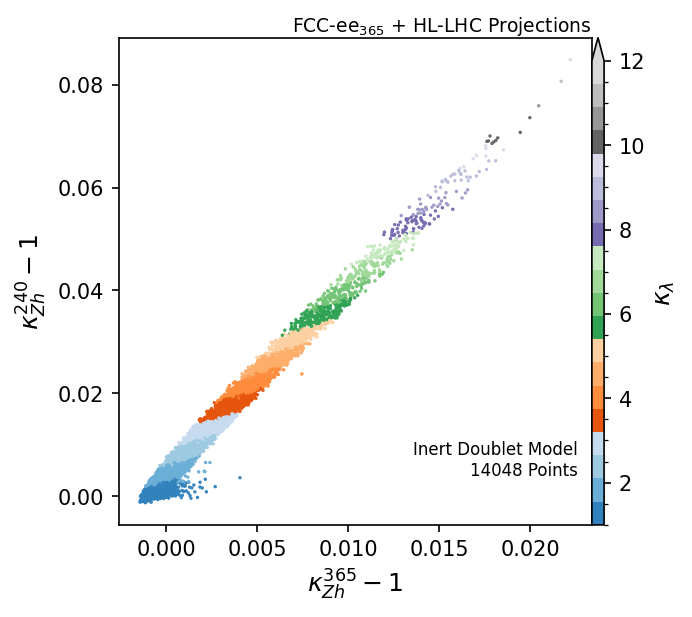

In [8]:
plot_dir="plots/IDM/new_data"
data_file="data/IDM/allIDMpoints_2025-01-14"
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                )

Processing data file: data/IDM/allIDMpoints_2025-01-14
[-5, -5, -4, -4, -3, -3, -2, -2, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10]
{-5: np.float64(0.9279440521594797), -4: np.float64(0.9444042023718197), -3: np.float64(0.9589849320887761), -2: np.float64(0.9717708430928765), -1: np.float64(0.9828319856384048), 0: np.float64(0.9922260435499478), 1: np.float64(1.0), 2: np.float64(1.0061914069885416), 3: np.float64(1.0108293446430638), 4: np.float64(1.0139351308056324), 5: np.float64(1.015522822967809), 6: np.float64(1.0155995408878167), 7: np.float64(1.0141656274647377), 8: np.float64(1.0112146564437785), 9: np.float64(1.0067332873600823), 10: np.float64(1.0007009600012033)}
{-5: np.float64(0.963853672815263), -4: np.float64(0.9739151638320371), -3: np.float64(0.9823142364237928), -2: np.float64(0.9890932417199596), -1: np.float64(0.9942853169728002), 0: np.float64(0.997915232510091), 1: np.float64(1.0), 2: np.float64(1.000549278007183), 3: np.float64(0.9

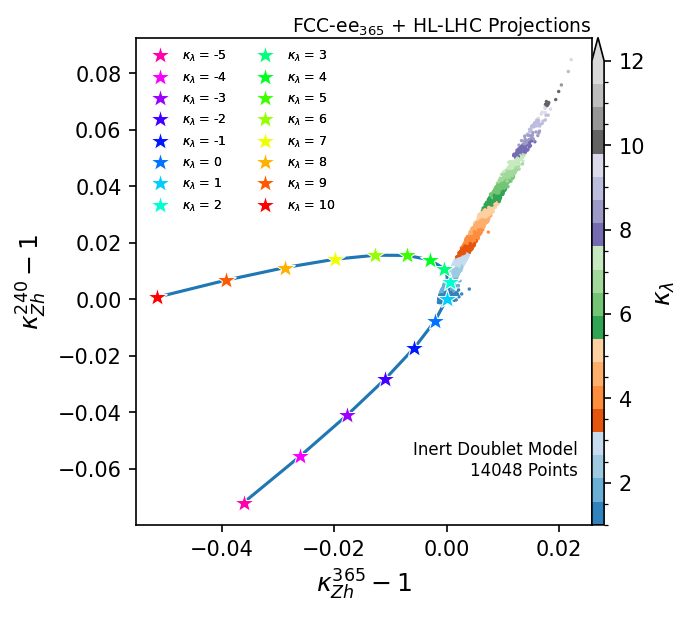

In [9]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                        plot_self_consistent_curve='CH',
                        plot_name_suffix='_with_self_consistent_curve_CH',
                )

Processing data file: data/IDM/allIDMpoints_2025-01-14
[0.9, 0.9, 0.95, 0.95, 1.0, 1.0, 1.05, 1.05, 1.1, 1.1, 1.15, 1.15, 1.2, 1.2]
{0.9: np.float64(0.9653586164317488), 0.95: np.float64(0.9828338857592803), 1.0: np.float64(1.0), 1.05: np.float64(1.016872616077826), 1.1: np.float64(1.0334661092573731), 1.15: np.float64(1.0497937154335761), 1.2: np.float64(1.0658676537308645)}
{0.9: np.float64(0.9659494060471608), 0.95: np.float64(0.9831240742442469), 1.0: np.float64(1.0), 1.05: np.float64(1.0165920612354993), 1.1: np.float64(1.032913937489339), 1.15: np.float64(1.0489782408982886), 1.2: np.float64(1.0647966293250806)}


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

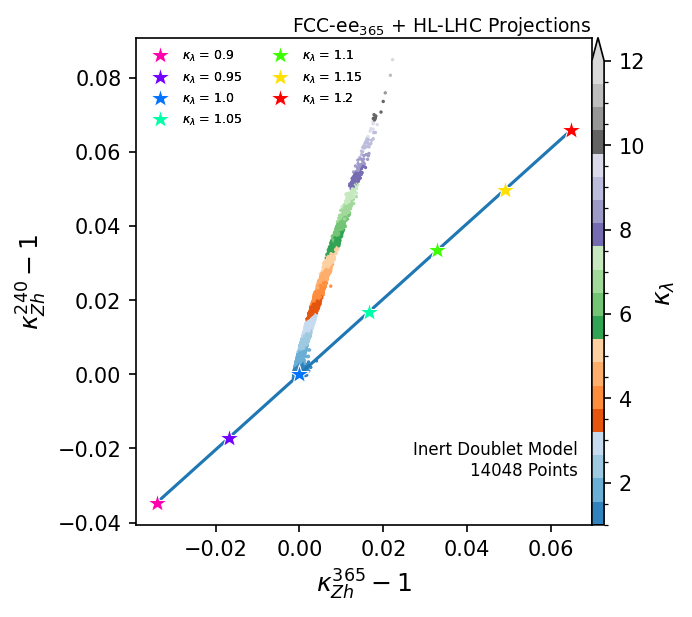

In [10]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                        plot_self_consistent_curve='CHbox',
                        plot_name_suffix='_with_self_consistent_curve_CHbox',
                )

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']
[-5, -5, -4, -4, -3, -3, -2, -2, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10]
{-5: np.float64(0.9279440521594797), -4: np.float64(0.9444042023718197), -3: np.float64(0.9589849320887761), -2: np.float64(0.9717708430928765), -1: np.float64(0.9828319856384048), 0: np.float64(0.9922260435499478), 1: np.float64(1.0), 2: np.float64(1.0061914069885416), 3: np.float64(1.0108293446430638), 4: np.float64(1.0139351308056324), 5: np.float64(1.015522822967809), 6: np.float64(1.0155995408878167), 7: np.float64(1.0141656274647377), 8: np.float64(1.0112146564437785), 9: np.float64(1.0067332873600823), 10: np.float64(1.0007009600012033)}
{-5: np.float64(0.963853672815263), -4: np.float64(0.9739151638320371), -3: np.float64(0.9823142364237928), -2: np.fl

(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

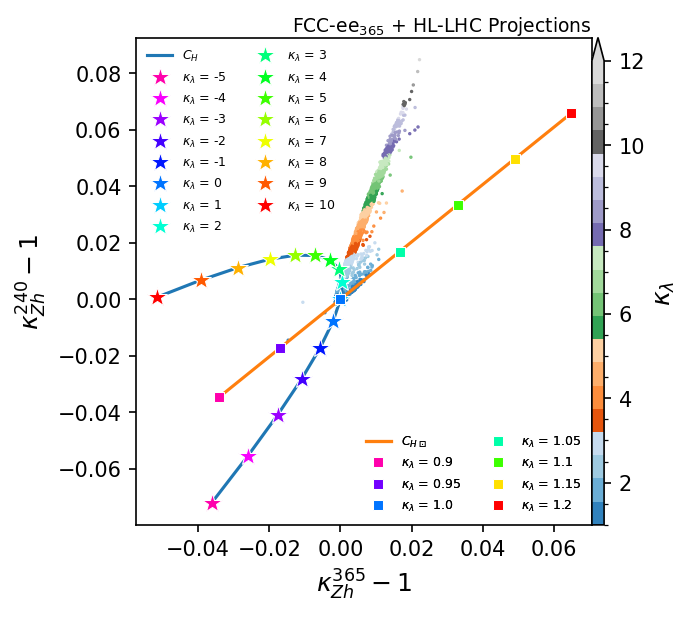

In [11]:
# data_file = "data/IDM/allIDMpoints_2025-01-14"
data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints_2025-01-17",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]
plot_dir = "plots/IDM"
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                        plot_self_consistent_curve=['CH', 'CHbox'],
                        plot_name_suffix='_with_self_consistent_curve_CH_CHbox',
                        no_model_text=True
                )

In [12]:
def plot_self_consistent_curve(curves, files, fig, ax, labels, colors_line, markers, markersizes, n_legends=1):
    if not curves is None:
        
        legend_loc = "best"
        colors = mpl.colormaps['hsv']

        # print( list(isinstance(arg, list) for arg in (curves, files, labels, colors_line, markers, markersizes)))
        # print( list(len(curves) == len(arg) for arg in (files, labels, colors_line, markers, markersizes)))

        if all([isinstance(arg, str) for arg in (curves, files, labels, colors_line, markers, markersizes)]):

            leg_handles = []

            lambdas=[]
            k_ZH_240 = {}
            k_ZH_365 = {}

            file_name = files

            with open(file_name, "r") as self_consistent_results_file:
                lines = self_consistent_results_file.readlines()
                for n, line in enumerate(lines):
                    columns = line.split()

                    if curves=='CH':
                        lmbd = int(columns[0])
                    if curves=='CHbox':
                        lmbd = float(columns[0])

                    lambdas.append(lmbd)
                    if columns[1].startswith("eeZH_FCCee240"):
                        k_ZH_240[lmbd] = np.sqrt(float(columns[2]))
                    elif columns[1].startswith("eeZH_FCCee365"):
                        k_ZH_365[lmbd] = np.sqrt(float(columns[2]))

            print(lambdas)
            print(k_ZH_240)
            print(k_ZH_365)

            lambdas_unique = [lmbd for i, lmbd in enumerate(lambdas) if i%2==0 ]
            
            color = list(colors(np.linspace(0.001, 0.9, len(lambdas_unique))[::-1]))

            ax.plot([(k_ZH_365[lmbd]-1) for lmbd in lambdas_unique],
                    [(k_ZH_240[lmbd]-1) for lmbd in lambdas_unique],
            )

            for i, lmbd in enumerate(lambdas_unique):
                ax.plot((k_ZH_365[lmbd]-1), (k_ZH_240[lmbd]-1), marker="*", ls="none", c=color[i], markersize=10, markeredgecolor='white', markeredgewidth=0.5)

                point_label = rf"$\kappa_\lambda$ = {lmbd}"
                leg_handles.append(Line2D([0], [0], color="k", ls="none", marker="*", c=color[i], markersize=10, markeredgecolor='white', markeredgewidth=0.5, label=point_label))

            hsLegend = ax.legend(
                        handles=leg_handles,
                        loc=legend_loc,
                        frameon=False,
                        prop={'size': 6},
                        ncol=2,
                    )
            ax.add_artist(hsLegend)


        elif all(isinstance(arg, list) for arg in (curves, files, labels, colors_line, markers, markersizes)) \
            and all( len(curves) == len(arg) for arg in (files, labels, colors_line, markers, markersizes)):
            # and all( isinstance(item, str) for arg in (curves, files, labels, colors_line, markers, markersizes) for item in arg) \

            # if curves==["CH", "CHbox"]:

            lambdas = {}
            k_ZH_240 = {}
            k_ZH_365 = {}
            
            for wc_index, (WC, file_name, label_line, color_line, marker, markersize) in enumerate(zip(curves, files, labels, colors_line, markers, markersizes)):

                if wc_index == 0:
                    leg_handles = []
                    leg_handles_lines = []
                
                lambdas[WC] = []
                k_ZH_240[WC] = {}
                k_ZH_365[WC] = {}

                if WC=='CH':
                    legend_loc='upper left'
                elif WC=='CHbox':
                    legend_loc='lower right'

                legend_loc_lines='lower right'


                with open(file_name, "r") as self_consistent_results_file:
                    lines = self_consistent_results_file.readlines()
                    for n, line in enumerate(lines):
                        columns = line.split()

                        if WC=='CH':
                            lmbd = int(columns[0])
                        if WC=='CHbox':
                            lmbd = float(columns[0])

                        lambdas[WC].append(lmbd)
                        if columns[1].startswith("eeZH_FCCee240"):
                            k_ZH_240[WC][lmbd] = np.sqrt(float(columns[2]))
                        elif columns[1].startswith("eeZH_FCCee365"):
                            k_ZH_365[WC][lmbd] = np.sqrt(float(columns[2]))

                print(lambdas[WC])
                print(k_ZH_240[WC])
                print(k_ZH_365[WC])

                lambdas_unique = [lmbd for i, lmbd in enumerate(lambdas[WC]) if i%2==0 ]
                
                color = list(colors(np.linspace(0.001, 0.9, len(lambdas_unique))[::-1]))

                ax.plot([(k_ZH_365[WC][lmbd]-1) for lmbd in lambdas_unique],
                        [(k_ZH_240[WC][lmbd]-1) for lmbd in lambdas_unique],
                        color=color_line,
                )
                leg_handles_lines.append(Line2D([0], [0], color="k", ls="-", c=color_line, label=label_line))
                print(leg_handles_lines)

                for i, lmbd in enumerate(lambdas_unique):
                    ax.plot((k_ZH_365[WC][lmbd]-1), (k_ZH_240[WC][lmbd]-1), marker=marker, ls="none", c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5)

                    point_label = rf"$\kappa_\lambda$ = {lmbd}"
                    if not (n_legends == 1 and wc_index != (len(curves) - 1)):
                        leg_handles.append(Line2D([0], [0], color="k", ls="none", marker=marker, c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5, label=point_label))

                # print(wc_index)
                # print(len(curves) - 1)
                if not (n_legends == 1 and wc_index != (len(curves) - 1)):
                    hsLegend = ax.legend(
                        handles=leg_handles,
                        loc=legend_loc,
                        frameon=False,
                        prop={'size': 6},
                        ncol=2,
                    )
                    ax.add_artist(hsLegend)

                    hsLegend_lines = ax.legend(
                        handles=leg_handles_lines,
                        loc=legend_loc_lines,
                        frameon=False,
                        prop={'size': 5},
                        ncol=1,
                    )
                    ax.add_artist(hsLegend_lines)

        else:
            raise ValueError("Please specify valid curves / files!")
        
    return fig, ax

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']
[-5, -5, -4, -4, -3, -3, -2, -2, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10]
{-5: np.float64(0.9279440521594797), -4: np.float64(0.9444042023718197), -3: np.float64(0.9589849320887761), -2: np.float64(0.9717708430928765), -1: np.float64(0.9828319856384048), 0: np.float64(0.9922260435499478), 1: np.float64(1.0), 2: np.float64(1.0061914069885416), 3: np.float64(1.0108293446430638), 4: np.float64(1.0139351308056324), 5: np.float64(1.015522822967809), 6: np.float64(1.0155995408878167), 7: np.float64(1.0141656274647377), 8: np.float64(1.0112146564437785), 9: np.float64(1.0067332873600823), 10: np.float64(1.0007009600012033)}
{-5: np.float64(0.963853672815263), -4: np.float64(0.9739151638320371), -3: np.float64(0.9823142364237928), -2: np.fl

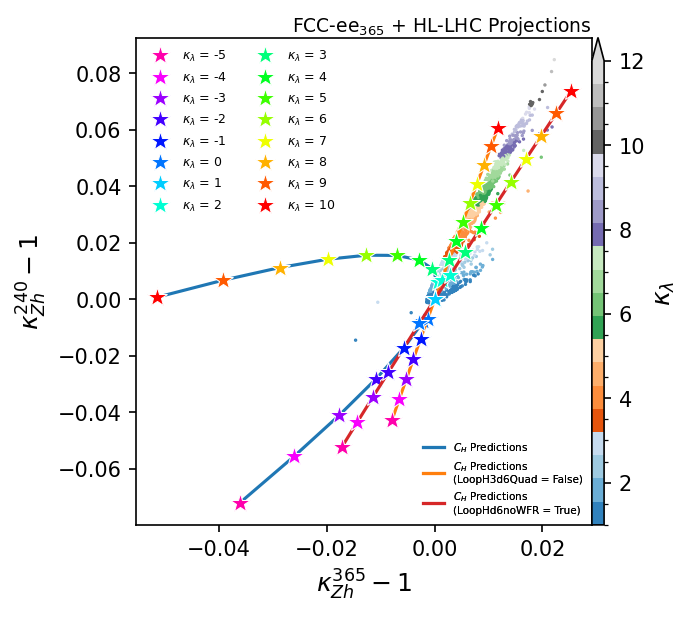

In [13]:
data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints_2025-01-17",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]
plot_dir = "plots/IDM"
plot_name = "IDM_results_k_ZH_240_vs_365"
plot_name_suffix = "_with_self_consistent_curves"
fig, ax = plot_EffZZH_240_vs_365(
    data_file, 
    plot_dir, 
    signals, 
    # plot_self_consistent_curve=['CH', 'CHbox'],
    # plot_name_suffix='_with_self_consistent_curve_CH',
    no_model_text=True
)

# plot_self_consistent_curve='CH',
# plot_name_suffix='_with_self_consistent_curve_CH',

curves = [
    "CH",
    "CH",
    "CH",
]

file_dir = "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee"
files = [
    f"{file_dir}/large_kappa_lambda_fits/comparison_plots/k_ZH_240_365_predictions.txt",
    f"{file_dir}/large_kappa_lambda_fits_noLoopH3d6Quad/comparison_plots/k_ZH_240_365_predictions.txt",
    # f"{file_dir}/large_kappa_lambda_fits_noSubleading/comparison_plots/k_ZH_240_365_predictions.txt",
    f"{file_dir}/large_kappa_lambda_fits_LoopHd6noWFR/comparison_plots/k_ZH_240_365_predictions.txt",
]

labels = [
    # r'$C_{H}$ Predictions'+' \n(LoopH3d6Quad = True)',
    r'$C_{H}$ Predictions'+'',
    r'$C_{H}$ Predictions'+' \n(LoopH3d6Quad = False)',
    # r'$C_{H}$ Predictions'+' \n(LoopHd6NoSubleading = True)',
    r'$C_{H}$ Predictions'+' \n(LoopHd6noWFR = True)',
    # r'$C_{H\boxdot}$',
]

colors = [
    "tab:blue",
    "tab:orange",
    "tab:red",
]

markers = [
    "*",
    "*",
    "*",
]

markersizes = [
    10,
    10,
    10,
]

fig, ax = plot_self_consistent_curve(
    curves, 
    files, 
    fig, 
    ax, 
    labels, 
    colors, 
    markers, 
    markersizes, 
    n_legends=1
)

plt.show()
fig.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+".pdf")


Processing data file: data/IDM/allIDMpoints_2025-01-14
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

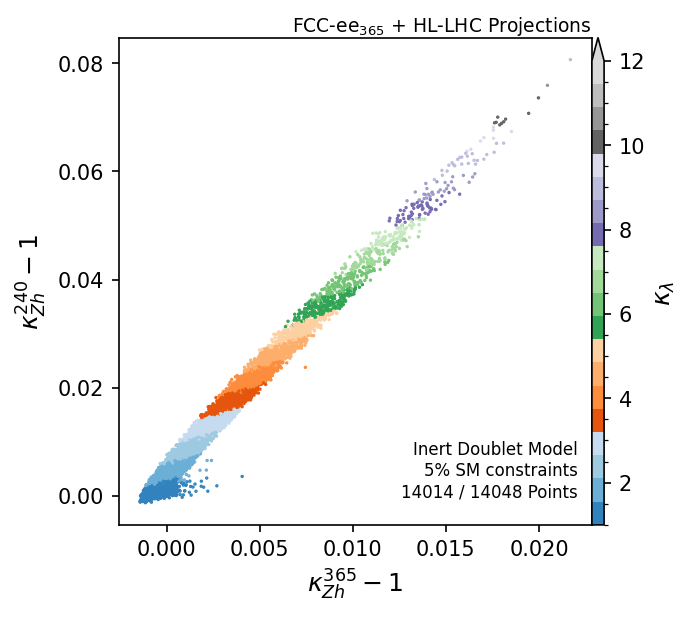

In [14]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.05
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=BR_constraints
                )

Processing data file: allIDMpoints_2025-01-14
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


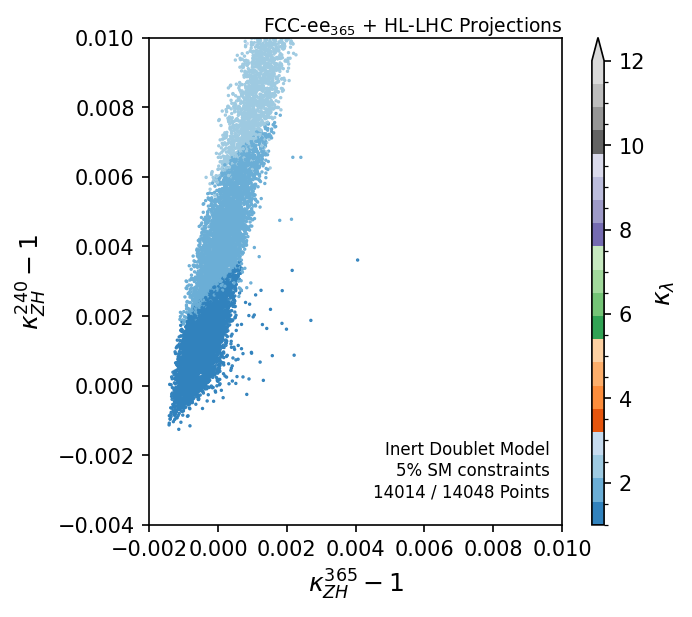

In [ ]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.05
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                       zoom=True,
                       zoom_range_x=(-0.002, 0.01), 
                       zoom_range_y=(-0.004, 0.01),
                )

Processing data file: allIDMpoints_2025-01-14
Number of points satisfying the 1% SM constraint on the single higgs couplings: 533 / 14048


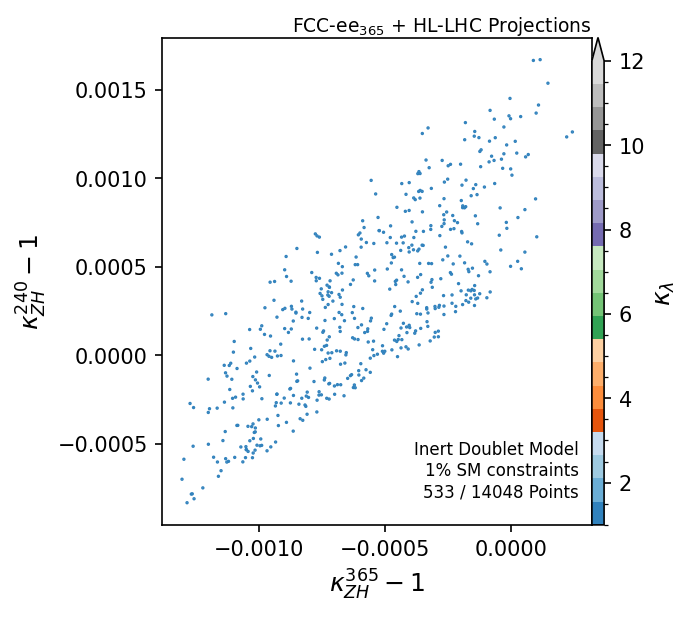

In [ ]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.01
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=BR_constraints
                )

### Finding Outlier Points 

In [15]:
full=True
BR_constraints=0.05
data_file="data/IDM/allIDMpoints_2025-01-14"
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna()
old_df_indices = df.index.to_numpy()
df = df.reset_index(drop=True)

kappas, EWPOs, model_pars = read_IDM_file(df)

def print_to_file(message, file):
    print(message)
    print(message, file=file)

def find_benchmark(df,
                   kappas,
                   EWPOs,
                   old_df_indices,
                   BP_Names,
                   BP_output_file,
                   max_errors_365,
                   max_errors_240,
                   delta_kappas_z_365,
                   delta_kappas_z_240,
                   BR_constraints=None,
                   ):

    n_pts = df.shape[0]

    if not BR_constraints is None:
        satisfy_BR_constraint = [True for i in range(n_pts)]
        for i in range(n_pts):
            for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam']:
                if np.abs(kappas[coup][i] - 1.) > BR_constraints:
                    satisfy_BR_constraint[i] = False

        for coup in kappas.keys():
            kappas[coup] = np.array(kappas[coup][satisfy_BR_constraint])
        
        for ewpo in EWPOs.keys():
            EWPOs[ewpo] = np.array(EWPOs[ewpo][satisfy_BR_constraint])

        for par in model_pars.keys():
            model_pars[par] = np.array(model_pars[par][satisfy_BR_constraint])

        old_df_indices = old_df_indices[satisfy_BR_constraint]

    chisq = np.full((n_pts,), np.nan)
    delta_kZ_240_365 = np.full((n_pts,), np.nan)
        

    if not len(delta_kappas_z_365) == len(delta_kappas_z_240):
        raise ValueError("delta_kappas_z_365 and delta_kappas_z_240 have different lengths!")

    bp_indices = [None for i in range(len(delta_kappas_z_365))]
    bp_kappas = [None for i in range(len(delta_kappas_z_365))]
    bp_EWPOs = [None for i in range(len(delta_kappas_z_365))]
    bp_model_pars = [None for i in range(len(delta_kappas_z_365))]

    for ind, (kZ_365, kZ_240) in enumerate(zip(kappas['ZZ_365'], kappas['ZZ_240'])):
        for BP, (delta_kappa_z_365, delta_kappa_z_240, max_error_365, max_error_240) in enumerate(zip(delta_kappas_z_365, delta_kappas_z_240, max_errors_365, max_errors_240)):
            if abs((kZ_365-1) - delta_kappa_z_365) < max_error_365 and abs((kZ_240-1) - delta_kappa_z_240) < max_error_240:
                bp_indices[BP] = ind


    if any(bp_index is None for bp_index in bp_indices):
        missing_BPs = [i for i, bp_index in enumerate(bp_indices) if bp_index is None]
        raise ValueError(f"The following BPs were not found: {missing_BPs}")


    for BP, bp_index in enumerate(bp_indices):

        print_to_file(f"\nelif BP == \"{BP_Names[BP]}\":", file=BP_output_file)

        # bfp_chisq = chisq[bp_index]
        bp_kappas[BP] = {coup:kps[bp_index] for (coup, kps) in kappas.items()}
        bp_EWPOs[BP] = {obs_name:obs_value[bp_index] for (obs_name, obs_value) in EWPOs.items()}
        bp_model_pars[BP] = {par_name:par_value[bp_index] for (par_name, par_value) in model_pars.items()}

        for coup, kaps in bp_kappas[BP].items():
            print_to_file(f"    kappas['{coup}'] = {kaps}", file=BP_output_file)

        print_to_file(f"    # abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = {np.abs((bp_kappas[BP]['ZZ_365'] - bp_kappas[BP]['ZZ_240'])/(bp_kappas[BP]['ZZ_240'] - 1))}", file=BP_output_file)
        print_to_file(f"    # abs(kappas['ZZ_365'] - kappas['ZZ_240']) = {np.abs(bp_kappas[BP]['ZZ_365'] - bp_kappas[BP]['ZZ_240'])}", file=BP_output_file)

        for obs_name, obs_value in bp_EWPOs[BP].items():
            print_to_file(f"    {obs_name} = {obs_value}", file=BP_output_file)

        for par_name, par_value in bp_model_pars[BP].items():
            print_to_file(f"    # {par_name} = {par_value}", file=BP_output_file)

        print_to_file(f"    # Best scan point row: {old_df_indices[bp_index]+2} out of {old_df_indices[-1]+2}", file=BP_output_file)

        if delta_kZ_240_365[bp_index] == np.inf: 
            raise ValueError("Could not find point satisfying the constraints!")
        
    return bp_kappas, bp_EWPOs, bp_model_pars


output_dir = "./scan_output/IDM_scan_output"
subprocess.run(["mkdir", "-p", output_dir])

BP_filename = f"{output_dir}/Benchmark_Points_outliers.txt"
BR_constraint=0.05
with open(BP_filename, "w") as BP_output_file:

    max_errors_365 = [1e-3, 1e-3, 1e-3, 1e-3, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 4e-4, 4e-4, 4e-4]
    max_errors_240 = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 2e-3, 2e-3, 2e-3]
    delta_kappas_z_365 = [0.0075, 0.004, -0.0024, 0.001, 0.0001, 0.0024, 0.0017, 0.0046, 0.0040, 0.0068, 0.0063, 0.0092, 0.0086, 0.0116, 0.011, 0.0140, 0.0140, 0.0165, 0.0164, 0.0195, 0.022]
    delta_kappas_z_240 = [0.023, 0.004, -0.0020, -0.0005, 0.008, 0.009, 0.016, 0.017, 0.0225, 0.025, 0.0325, 0.033, 0.040, 0.041, 0.049, 0.051, 0.058, 0.060, 0.066, 0.071, 0.08]



    BP_Names = ["BPO_0", "BPO_1"]
    BP_Names = BP_Names + [f"BPB_{i}" for i in range(len(delta_kappas_z_240)-2)]
    BP_Names_legend = ["BPO 0", "BPO 1"]
    BP_Names_legend = BP_Names_legend + [f"BPB {i}" for i in range(len(delta_kappas_z_240)-2)]

    bp_kappas , bp_EWPOs, bp_model_pars = find_benchmark(df=df,
                               EWPOs=EWPOs,
                               kappas=kappas,
                               old_df_indices=old_df_indices,
                               BP_Names=BP_Names,
                               BP_output_file=BP_output_file,
                               max_errors_365=max_errors_365,
                               max_errors_240=max_errors_240,
                               delta_kappas_z_365=delta_kappas_z_365,
                               delta_kappas_z_240=delta_kappas_z_240,
                               BR_constraints=BR_constraints,
                              )


elif BP == "BPO_0":
    kappas['uu'] = 0.9818547810617284
    kappas['dd'] = 0.9818547810617284
    kappas['ss'] = 0.9818547810617284
    kappas['cc'] = 0.9818547810617284
    kappas['bb'] = 0.9818547810617284
    kappas['tt'] = 0.9818547810617284
    kappas['ee'] = 0.9818547810617284
    kappas['mumu'] = 0.9818547810617284
    kappas['tautau'] = 0.9818547810617284
    kappas['ZZ_0'] = 1.007141704579298
    kappas['ZZ_240'] = 1.0237693288776533
    kappas['ZZ_365'] = 1.0074536101415776
    kappas['ZZ_500'] = 1.0026988104523176
    kappas['ZZ_550'] = 1.0021232678597285
    kappas['ZZ'] = 0.9899392240917029
    kappas['WW'] = 0.9899392240917029
    kappas['lam'] = 4.038636858901748
    kappas['gamgam'] = 0.9514322699531608
    kappas['Zgam'] = 0.9820015140523058
    # abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = 0.6864189906268178
    # abs(kappas['ZZ_365'] - kappas['ZZ_240']) = 0.016315718736075624
    Mw = 80.35863800163634
    sin2thetaEff = 0.2314855517673455
  

In [16]:
print("std::vector<float> base_KappaLambdas = {")
for BP, BP_name in zip(bp_kappas, BP_Names):
    print(f"        {BP["lam"]}, // {BP_name}")
print("    };")

std::vector<float> base_KappaLambdas = {
        4.038636858901748, // BPO_0
        1.2385642568656816, // BPO_1
        1.1209067864736006, // BPB_0
        1.1119460475058272, // BPB_1
        2.3867362274064843, // BPB_2
        2.296737570137434, // BPB_3
        3.3446699219962595, // BPB_4
        3.3186760761499228, // BPB_5
        4.332584967850238, // BPB_6
        4.324280052220163, // BPB_7
        5.390968560325193, // BPB_8
        5.289906405452073, // BPB_9
        6.370034303736775, // BPB_10
        6.270579956517072, // BPB_11
        7.515862276796717, // BPB_12
        7.466008740779396, // BPB_13
        8.611459058586306, // BPB_14
        8.459762817722257, // BPB_15
        9.319513844125106, // BPB_16
        9.888810967739037, // BPB_17
        11.2535829810942, // BPB_18
    };


### Plotting the obtained points

Processing data file: data/IDM/allIDMpoints_2025-01-14
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

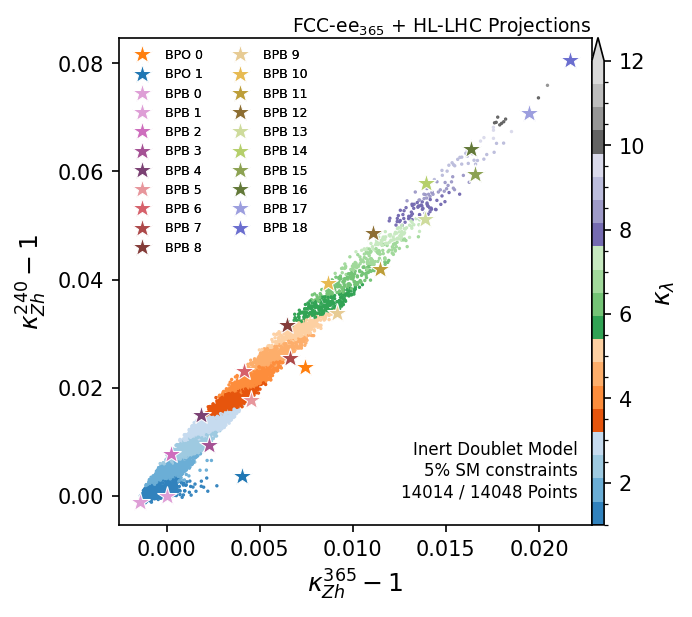

In [17]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.05
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, label) for BP, label in zip(bp_kappas, BP_Names_legend)]

plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                       plot_points=plot_points,
                )

## Plotting the obtained points including the Higgs self-energy contributions to $\sigma_{Zh}$

In [43]:
# Johannes' formula
sqrt = np.sqrt
Mh = 125.1
vev = 246.21965
def ZZh_hextleg(kala):
    dZh = -(Mh**2*(-9 + 2*np.sqrt(3)*np.pi))/(32*np.pi**2*vev**2)
    return (kala**2-1)*dZh

# kappas['ZZ_0']   = sqrt( kappas["ZZ_0"]**2   + ZZh_hextleg( kappas["lam"] ) )
# kappas['ZZ_240'] = sqrt( kappas['ZZ_240']**2 + ZZh_hextleg( kappas["lam"] ) )
# kappas['ZZ_365'] = sqrt( kappas['ZZ_365']**2 + ZZh_hextleg( kappas["lam"] ) )
# kappas['ZZ_500'] = sqrt( kappas['ZZ_500']**2 + ZZh_hextleg( kappas["lam"] ) )

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']
[-5, -5, -4, -4, -3, -3, -2, -2, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10]
{-5: np.float64(0.9279440521594797), -4: np.float64(0.9444042023718197), -3: np.float64(0.9589849320887761), -2: np.float64(0.9717708430928765), -1: np.float64(0.9828319856384048), 0: np.float64(0.9922260435499478), 1: np.float64(1.0), 2: np.float64(1.0061914069885416), 3: np.float64(1.0108293446430638), 4: np.float64(1.0139351308056324), 5: np.float64(1.015522822967809), 6: np.float64(1.0155995408878167), 7: np.float64(1.0141656274647377), 8: np.float64(1.0112146564437785), 9: np.float64(1.0067332873600823), 10: np.float64(1.0007009600012033)}
{-5: np.float64(0.963853672815263), -4: np.float64(0.9739151638320371), -3: np.float64(0.9823142364237928), -2: np.fl

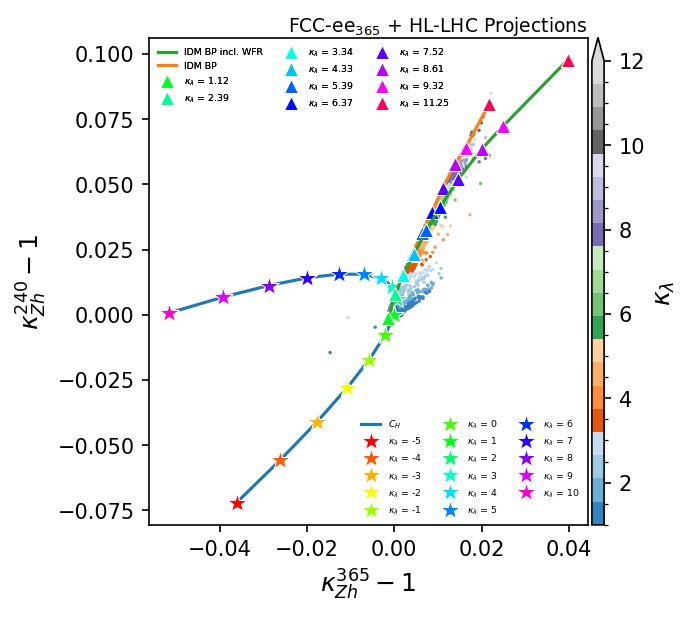

<Figure size 960x720 with 0 Axes>

In [66]:
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, BP["lam"], label) for BP, label in zip(bp_kappas, BP_Names_legend)]
plot_points_with_WFR = [
    (sqrt( (BP["ZZ_365"])**2 + ZZh_hextleg( BP["lam"] )**2 ) - 1,
     sqrt( (BP["ZZ_240"])**2 + ZZh_hextleg( BP["lam"] )**2 ) - 1,
     BP["lam"],
     label, ) for BP, label in zip(bp_kappas, BP_Names_legend)
]
plot_points = plot_points[2::2]
plot_points_with_WFR = plot_points_with_WFR[2::2]


data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints_2025-01-17",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]

plot_dir = "plots/IDM"
plot_name = "IDM_results_k_ZH_240_vs_365"
plot_name_suffix = "_with_self_consistent_curves_with_WFR"

fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True
                )

curves = [
    "CH", 
    # "CHbox", 
    "IDM",
    "IDM_SMEFT",
]
file_names = [
    "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits/comparison_plots/k_ZH_240_365_predictions.txt",
    # "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits_CHbox/comparison_plots/k_ZH_240_365_predictions.txt",
    None,
    None,
]
data_sets = [
    None,
    plot_points,
    plot_points_with_WFR,
]
legend_locs = [
    'lower right',
    '*upper left',
    None,
]
markers = [
    "*", 
    "^",
    "^",
]
color_lines = [
    "tab:blue", 
    "tab:orange",
    "tab:green",
]
label_lines = [
    r'$C_{H}$', 
    # r'$C_{H\boxdot}$',
    r'IDM BP',
    r'IDM BP incl. WFR',
]
markersizes = [
    10, 
    7,
    7,
]


def plot_curve (curves, file_names, data_sets, legend_locs, markers, color_lines, label_lines, markersizes):

    colors = mpl.colormaps['hsv']
    norm = Normalize(vmin=-5.0, vmax=12.)

    lambdas = {}
    k_ZH_240 = {}
    k_ZH_365 = {}

    for curve, file_name, data_set, legend_loc, marker, color_line, label_line, markersize in zip(curves, file_names, data_sets, legend_locs, markers, color_lines, label_lines, markersizes):

        if legend_loc is not None: leg_handles = []
        lambdas[curve] = []
        k_ZH_240[curve] = {}
        k_ZH_365[curve] = {}

        if file_name is not None and data_set is None:

            with open(file_name, "r") as self_consistent_results_file:
                lines = self_consistent_results_file.readlines()
                for n, line in enumerate(lines):
                    columns = line.split()

                    if curve=='CH':
                        lmbd = int(columns[0])
                    elif curve=='CHbox':
                        lmbd = float(columns[0])
                    else:
                        lmbd = float(columns[0])

                    lambdas[curve].append(lmbd)
                    if columns[1].startswith("eeZH_FCCee240"):
                        k_ZH_240[curve][lmbd] = np.sqrt(float(columns[2]))
                    elif columns[1].startswith("eeZH_FCCee365"):
                        k_ZH_365[curve][lmbd] = np.sqrt(float(columns[2]))

            lambdas_unique = [lmbd for i, lmbd in enumerate(lambdas[curve]) if i%2==0 ]

        elif file_name is None and data_set is not None:
            for bp in data_set:
                lmbd = bp[2]
                lambdas[curve].append(lmbd)
                k_ZH_365[curve][lmbd] = bp[0] + 1
                k_ZH_240[curve][lmbd] = bp[1] + 1
            lambdas_unique = lambdas[curve]
        else:
            raise ValueError("Please specify valid curves / files!")

        print(lambdas[curve])
        print(k_ZH_240[curve])
        print(k_ZH_365[curve])
        
        # color = list(colors(np.linspace(0.001, 0.9, len(lambdas_unique))[::-1]))
        color = list(colors(norm(np.array(lambdas_unique))))

        ax.plot([(k_ZH_365[curve][lmbd]-1) for lmbd in lambdas_unique],
                [(k_ZH_240[curve][lmbd]-1) for lmbd in lambdas_unique],
                color=color_line,
        )
        if legend_loc is not None:
            leg_handles.append(Line2D([0], [0], color="k", ls="-", c=color_line, label=label_line))
        else:
            leg_handles = [Line2D([0], [0], color="k", ls="-", c=color_line, label=label_line)] + leg_handles

        for i, lmbd in enumerate(lambdas_unique):
            ax.plot((k_ZH_365[curve][lmbd]-1), (k_ZH_240[curve][lmbd]-1), marker=marker, ls="none", c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5)

            if isinstance(lmbd, int):
                point_label = rf"$\kappa_\lambda$ = {lmbd}"
            else:
                point_label = rf"$\kappa_\lambda$ = {lmbd:.2f}"
            
            if legend_loc is not None:
                leg_handles.append(Line2D([0], [0], color="k", ls="none", marker=marker, c=color[i], markersize=markersize, markeredgecolor='white', markeredgewidth=0.5, label=point_label))

        if legend_loc is None or not legend_loc.startswith("*"):
            hsLegend = ax.legend(
                handles=leg_handles,
                loc=legend_loc,
                frameon=False,
                prop={'size': 4.5},
                ncol=3,
            )
            ax.add_artist(hsLegend)

plot_curve(curves, file_names, data_sets, legend_locs, markers, color_lines, label_lines, markersizes)

plt.show()

plt.savefig(f'{plot_dir}/{plot_name}{plot_name_suffix}'+".pdf")



In [67]:
M_PI = 3.14159265358979323846
GF = 1.1663787e-5
mHl = 125.1
sqrt = np.sqrt

def smeft_sigma_Zh(lmbd, sqrt_s):
    mu = 1

    if sqrt_s == 240:
        C1 = 0.017
    elif sqrt_s == 365:
        C1 = 0.0057
    elif sqrt_s == 500:
        C1 = 0.00099
    else:
        raise ValueError("sqrt_s must be 240, 365, or 500 GeV")

    # Expression for the Higgs self-energy diagram
    dZH = -(9.0/16.0)*( GF*mHl*mHl/sqrt(2.0)/M_PI/M_PI )*( 2.0*M_PI/3.0/sqrt(3.0) - 1.0 )
    
    # Resummations
    dZH1 = dZH / (1.0 - dZH)
    dZH2 = dZH * (1 + 3.0 * dZH) / (1.0 - dZH) / (1.0 - dZH)

    # HEPfit flags
    cLHd6 = 1
    cLH3d62 = 1

    deltaG_hhhRatio = lmbd - 1

    mu = mu + cLHd6*(C1 + 2.0*dZH1)*deltaG_hhhRatio

    mu = mu + cLHd6*cLH3d62*dZH2*deltaG_hhhRatio*deltaG_hhhRatio

    return mu

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17', 'data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/outlierIDMpoints4_2025-01-17']
[-5, -5, -4, -4, -3, -3, -2, -2, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10]
{-5: np.float64(0.9279440521594797), -4: np.float64(0.9444042023718197), -3: np.float64(0.9589849320887761), -2: np.float64(0.9717708430928765), -1: np.float64(0.9828319856384048), 0: np.float64(0.9922260435499478), 1: np.float64(1.0), 2: np.float64(1.0061914069885416), 3: np.float64(1.0108293446430638), 4: np.float64(1.0139351308056324), 5: np.float64(1.015522822967809), 6: np.float64(1.0155995408878167), 7: np.float64(1.0141656274647377), 8: np.float64(1.0112146564437785), 9: np.float64(1.0067332873600823), 10: np.float64(1.0007009600012033)}
{-5: np.float64(0.963853672815263), -4: np.float64(0.9739151638320371), -3: np.float64(0.9823142364237928), -2: np.fl

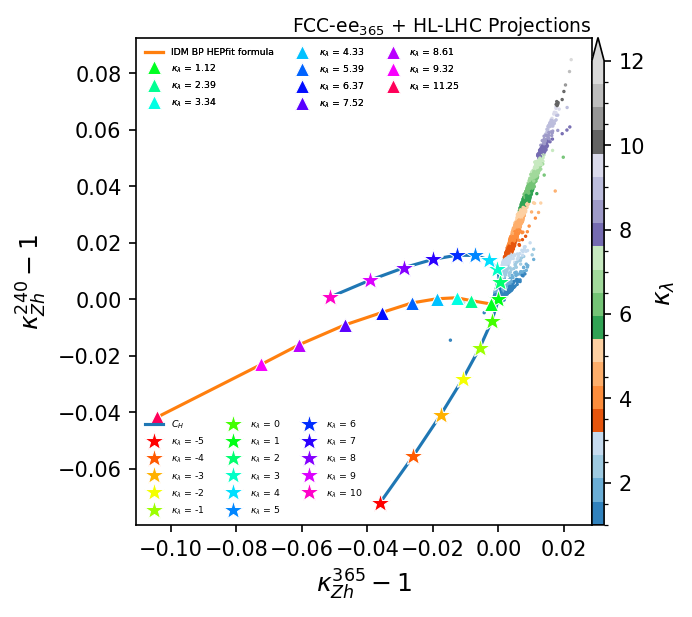

In [69]:
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, BP["lam"], label) for BP, label in zip(bp_kappas, BP_Names_legend)]
sqrt(smeft_sigma_Zh(lmbd=kappas["lam"], sqrt_s=240) + 2*(kappas["uu"]-1))
plot_points_HEPfit_formula = [
    (sqrt(smeft_sigma_Zh(lmbd=BP["lam"], sqrt_s=365) + 2*(BP["uu"]-1)) - 1,
     sqrt(smeft_sigma_Zh(lmbd=BP["lam"], sqrt_s=240) + 2*(BP["uu"]-1)) - 1,
     BP["lam"],
     label, ) for BP, label in zip(bp_kappas, BP_Names_legend)
]
plot_points = plot_points[2::2]
plot_points_HEPfit_formula = plot_points_HEPfit_formula[2::2]


data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints_2025-01-17",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]

plot_dir = "plots/IDM"
plot_name = "IDM_results_k_ZH_240_vs_365"
plot_name_suffix = "_with_self_consistent_curves_with_WFR"

fig, ax = plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                        # plot_self_consistent_curve=['CH', 'CHbox'],
                        plot_name_suffix=plot_name+plot_name_suffix,
                        no_model_text=True
                )

curves = [
    "CH", 
    # "CHbox", 
    # "IDM",
    "IDM_HEPfit",
]
file_names = [
    "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits/comparison_plots/k_ZH_240_365_predictions.txt",
    # "/cephfs/user/mrebuzzi/phd/HEPfit/HEPfit_snowmass21/Fits_HLLHC_FCCee/large_kappa_lambda_fits_CHbox/comparison_plots/k_ZH_240_365_predictions.txt",
    # None,
    None,
]
data_sets = [
    None,
    # plot_points,
    plot_points_HEPfit_formula,
]
legend_locs = [
    'lower left',
    'upper left',
    # None,
]
markers = [
    "*", 
    "^",
    # "^",
]
color_lines = [
    "tab:blue", 
    "tab:orange",
    # "tab:green",
]
label_lines = [
    r'$C_{H}$', 
    # r'$C_{H\boxdot}$',
    # r'IDM BP',
    r'IDM BP HEPfit formula',
]
markersizes = [
    10, 
    7,
    # 7,
]

plot_curve(curves, file_names, data_sets, legend_locs, markers, color_lines, label_lines, markersizes)

## Final plot for the 2-page document

[{'uu': np.float64(0.991329519562304), 'dd': np.float64(0.991329519562304), 'ss': np.float64(0.991329519562304), 'cc': np.float64(0.991329519562304), 'bb': np.float64(0.991329519562304), 'tt': np.float64(0.991329519562304), 'ee': np.float64(0.991329519562304), 'mumu': np.float64(0.991329519562304), 'tautau': np.float64(0.991329519562304), 'ZZ_0': np.float64(1.000248738282997), 'ZZ_240': np.float64(1.0077713199799205), 'ZZ_365': np.float64(1.0002131692051668), 'ZZ_500': np.float64(0.997795877018984), 'ZZ_550': np.float64(0.9973832902199067), 'ZZ': np.float64(0.9920448239572286), 'WW': np.float64(0.9920448239572286), 'lam': np.float64(2.3867362274064843), 'gamgam': np.float64(0.974955131015653), 'Zgam': np.float64(0.9907251332792432)}, {'uu': np.float64(0.9884079643889591), 'dd': np.float64(0.9884079643889591), 'ss': np.float64(0.9884079643889591), 'cc': np.float64(0.9884079643889591), 'bb': np.float64(0.9884079643889591), 'tt': np.float64(0.9884079643889591), 'ee': np.float64(0.98840796

(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

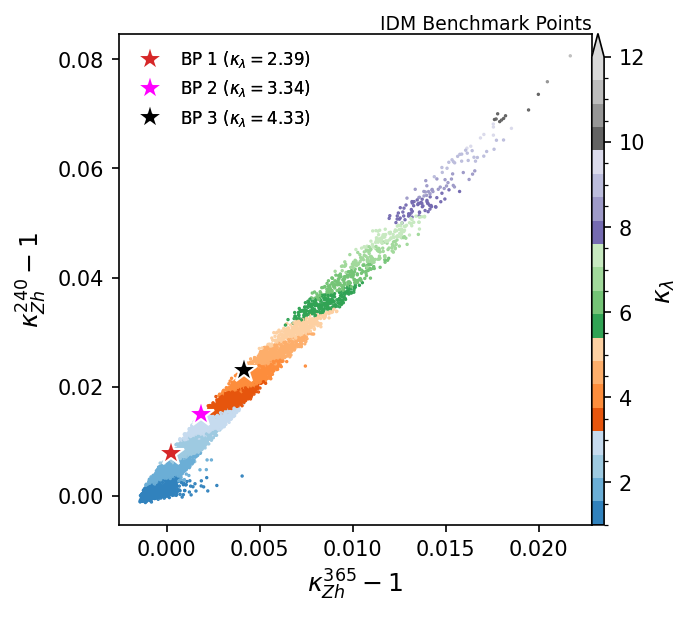

In [67]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.05
BPs_plot_final = ["BPB_2", "BPB_4", "BPB_6", ]


BP_Names_legend_plot_final = [rf"BP {i+1} ($\kappa_\lambda=${bp_kappas[BP_Names.index(BP)]["lam"]:.3g})"  for i, BP in enumerate(BPs_plot_final)]
bp_kappas_plot_final = [bp_kappas[BP_Names.index(BP)] for BP in BPs_plot_final]
print(bp_kappas_plot_final)
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, label, BP["lam"]) for BP, label in zip(bp_kappas_plot_final, BP_Names_legend_plot_final)]

plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                       plot_points=plot_points,
                      #  point_colors="lambdas",
                       point_colors=["tab:red", "fuchsia", "k"],
                       point_leg_columns=1,
                       point_leg_size=8,
                      #  point_marker_size=[13, 10, 10],
                       point_marker_size=[13, 13, 13],
                      #  point_markers=["*", "o", "^"],
                       point_markers=["*", "*", "*"],
                       no_model_text=True,
                       upper_right_text="IDM Benchmark Points",
                       plot_name_suffix="_final_2pager",
                       markeredgewidth=[1, 1, 1],
                )

### Generate table with model parameters

In [11]:
model_pars_names = [
    r"$\mu_2^2\;[\unit{\GeV^2}]$",
    r"$\lambda_1\;[\unit{\GeV}]$",
    r"$\lambda_2\;[\unit{\GeV}]$",
    r"$\lambda_3\;[\unit{\GeV}]$",
    r"$\lambda_4\;[\unit{\GeV}]$",
    r"$\lambda_5\;[\unit{\GeV}]$",
    r"$m_H\;[\unit{\GeV}]$",
    r"$m_A\;[\unit{\GeV}]$",
    r"$m_{H^{\pm}}\;[\unit{\GeV}]$",
]

model_pars = [
    "mu2sq", 
    "lam1", 
    "lam2", 
    "lam3", 
    "lam4", 
    "lam5", 
    "mH", 
    "mA", 
    "mHp",
]

first_line = ""
for par in model_pars_names:
    first_line = first_line + " & " + par
first_line = first_line + r" \\ \hline\hline"
print(first_line)

for i, BP in enumerate(BPs_plot_final):

    line = f"BP {i+1}"
    for par in model_pars:
        if par == "mu2sq":
            # line = line + f" & {bp_model_pars[BP_Names.index(BP)][par]:.6g}"
            line = line + rf" & \num[exponent-mode = scientific]{{{bp_model_pars[BP_Names.index(BP)][par]:.4}}}"
        else:
            line = line + f" & ${bp_model_pars[BP_Names.index(BP)][par]:.4g}$"
            # line = line + rf" & \SI{{{bp_model_pars[BP_Names.index(BP)][par]}}}"
    line = line + r" \\ \hline"
    print(line)

 & $\mu_2^2\;[\unit{\GeV^2}]$ & $\lambda_1\;[\unit{\GeV}]$ & $\lambda_2\;[\unit{\GeV}]$ & $\lambda_3\;[\unit{\GeV}]$ & $\lambda_4\;[\unit{\GeV}]$ & $\lambda_5\;[\unit{\GeV}]$ & $m_H\;[\unit{\GeV}]$ & $m_A\;[\unit{\GeV}]$ & $m_{H^{\pm}}\;[\unit{\GeV}]$ \\ \hline\hline
BP 1 & \num[exponent-mode = scientific]{3.666e+05} & $0.2581$ & $3.084$ & $11.46$ & $-5.68$ & $-5.109$ & $622.2$ & $834.8$ & $845.1$ \\ \hline
BP 2 & \num[exponent-mode = scientific]{3.922e+05} & $0.2581$ & $10.06$ & $14.19$ & $-6.974$ & $-6.407$ & $645.6$ & $897.3$ & $906.8$ \\ \hline
BP 3 & \num[exponent-mode = scientific]{3.432e+05} & $0.2581$ & $8.985$ & $15.83$ & $-7.704$ & $-7.4$ & $604.3$ & $902.1$ & $907.2$ \\ \hline


#### Generate latex code for slides

In [10]:
for i in range(8):

    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(rf"%%%%%%%%%%%%%%% BP {i} %%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"")
    print(r"\begin{frame}{FCC-ee results: IDM Benchmark Point "+f"{i}"+"}")
    print(r"    \begin{columns}")
    print(r"        \begin{column}{.50\textwidth}")
    print(r"            \vspace{-0.4cm}")
    print(r"            \centering")
    print(r"            \begin{figure}[h]")
    print(r"            \centering")
    print(r"            % trim={<left> <lower> <right> <upper>}")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_BP_"+f"{i}"+"_IDM_FCCee240.pdf}")
    print(r"            \centering")
    print(r"            \vspace{0.2cm}")
    print(r"            ")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_BP_"+f"{i}"+"_IDM_FCCee240_FCCee365.pdf}")
    print(r"            \centering")
    print(r"            \end{figure}")
    print(r"        \end{column}")
    print(r"        ")
    print(r"        ")
    print(r"        \begin{column}{.50\textwidth}")
    print(r"            \vspace{-0.5cm}")
    print(r"            \centering")
    print(r"            \begin{figure}[h]")
    print(r"            \centering")
    print(r"            % trim={<left> <lower> <right> <upper>}")
    print(r"            \includegraphics[trim={3mm, 3mm, 3mm, 2mm}, clip, width=0.95\textwidth]{comparison_plots/IDM/FCC_results/mean_stddev_0.pdf}")
    print(r"            \centering")
    print(r"            \vspace{0.5cm}")
    print(r"            ")
    print(r"            \end{figure}")
    print(r"        \end{column}")
    print(r"    \end{columns}")
    print(r"\end{frame}")
    print("\n")
    print("\n")

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%% BP 0 %%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

\begin{frame}{FCC-ee results: IDM Benchmark Point 0}
    \begin{columns}
        \begin{column}{.50\textwidth}
            \vspace{-0.4cm}
            \centering
            \begin{figure}[h]
            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_BP_0_IDM_FCCee240.pdf}
            \centering
            \vspace{0.2cm}
            
            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_BP_0_IDM_FCCee240_FCCee365.pdf}
            \centering
            \end{figure}
        \end{column}
        
        
        \begin{column}{.50\textwidth}
            \vspace{-0.5cm}
     

In [15]:
num_BPO = 2
num_BPB = 17
def generate_slide(BP, BP_name):

    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(rf"%%%%%%%%%%%%%%% {BP_name} %%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"")
    print(r"\begin{frame}{FCC-ee results: IDM Benchmark Point "+f"{BP_name}"+"}")
    print(r"    \begin{columns}")
    print(r"        \begin{column}{.50\textwidth}")
    print(r"            \vspace{-0.4cm}")
    print(r"            \centering")
    print(r"            \begin{figure}[h]")
    print(r"            \centering")
    print(r"            % trim={<left> <lower> <right> <upper>}")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_"+BP+"_IDM_FCCee240.pdf}")
    print(r"            \centering")
    print(r"            \vspace{0.2cm}")
    print(r"            ")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_"+BP+"_IDM_FCCee240_FCCee365.pdf}")
    print(r"            \centering")
    print(r"            \end{figure}")
    print(r"        \end{column}")
    print(r"        ")
    print(r"        ")
    print(r"        \begin{column}{.50\textwidth}")
    print(r"            \vspace{-0.5cm}")
    print(r"            \centering")
    print(r"            \begin{figure}[h]")
    print(r"            \centering")
    print(r"            % trim={<left> <lower> <right> <upper>}")
    print(r"            \includegraphics[trim={3mm, 3mm, 3mm, 2mm}, clip, width=0.95\textwidth]{comparison_plots/IDM/FCC_results/mean_stddev_0.pdf}")
    print(r"            \centering")
    print(r"            \vspace{0.5cm}")
    print(r"            ")
    print(r"            \end{figure}")
    print(r"        \end{column}")
    print(r"    \end{columns}")
    print(r"\end{frame}")
    print("\n")
    print("\n")

for i in range(num_BPO):
    generate_slide(f"BPO_{i}", f"BPO {i}")

for i in range(num_BPB):
    generate_slide(f"BPB_{i}", f"BPB {i}")


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%% BPO 0 %%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

\begin{frame}{FCC-ee results: IDM Benchmark Point BPO 0}
    \begin{columns}
        \begin{column}{.50\textwidth}
            \vspace{-0.4cm}
            \centering
            \begin{figure}[h]
            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_BPO_0_IDM_FCCee240.pdf}
            \centering
            \vspace{0.2cm}
            
            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_BPO_0_IDM_FCCee240_FCCee365.pdf}
            \centering
            \end{figure}
        \end{column}
        
        
        \begin{column}{.50\textwidth}
            \vspace{-0.5cm

In [18]:
num_BPO = 2
def generate_slide(BP, BP_name):

    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(rf"%%%%%%%%%%%%%%% {BP_name} %%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"")
    print(r"\begin{frame}{FCC-ee results: IDM Benchmark Point "+f"{BP_name}"+"}")
    print(r"    \begin{columns}")
    print(r"        \begin{column}{.33\textwidth}")
    print(r"            \vspace{-0.4cm}")
    print(r"            \centering")
    print(r"            \begin{figure}[h]")
    print(r"            \centering")
    print(r"            % trim={<left> <lower> <right> <upper>}")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_mod_SM_FCCee240.pdf}")
    print(r"            \centering")
    print(r"            \vspace{0.2cm}")
    print(r"            ")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_"+BP+"_IDM_FCCee240.pdf}")
    print(r"            \centering")
    print(r"            \end{figure}")
    print(r"        \end{column}")
    print(r"        ")
    print(r"        ")
    print(r"        \begin{column}{.33\textwidth}")
    print(r"            \vspace{-0.4cm}")
    print(r"            \centering")
    print(r"            \begin{figure}[h]")
    print(r"            \centering")
    print(r"            % trim={<left> <lower> <right> <upper>}")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_mod_SM_FCCee240_FCCee365.pdf}")
    print(r"            \centering")
    print(r"            \vspace{0.2cm}")
    print(r"            ")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_"+BP+"_IDM_FCCee240_FCCee365.pdf}")
    print(r"            \centering")
    print(r"            \end{figure}")
    print(r"        \end{column}")
    print(r"        \begin{column}{.33\textwidth}")
    print(r"            \vspace{-0.4cm}")
    print(r"            \centering")
    print(r"            \begin{figure}[h]")
    print(r"            \centering")
    print(r"            % trim={<left> <lower> <right> <upper>}")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_mod_SM_FCCee240_FCCee365_HLLHClambda.pdf}")
    print(r"            \centering")
    print(r"            \vspace{0.2cm}")
    print(r"            ")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_"+BP+"_IDM_FCCee240_FCCee365_HLLHClambda.pdf}")
    print(r"            \centering")
    print(r"            \end{figure}")
    print(r"        \end{column}")
    print(r"    \end{columns}")
    print(r"\end{frame}")
    print("\n")
    print("\n")

for i in range(num_BPO):
    generate_slide(f"BPO_{i}", f"BPO {i}")


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%% BPO 0 %%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

\begin{frame}{FCC-ee results: IDM Benchmark Point BPO 0}
    \begin{columns}
        \begin{column}{.33\textwidth}
            \vspace{-0.4cm}
            \centering
            \begin{figure}[h]
            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_mod_SM_FCCee240.pdf}
            \centering
            \vspace{0.2cm}
            
            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/IDM/FCC_results/deltalHHH_HLLHC_BPO_0_IDM_FCCee240.pdf}
            \centering
            \end{figure}
        \end{column}
        
        
        \begin{column}{.33\textwidth}
            \vspace{-0.4cm}
          

In [15]:
import math

In [28]:
n_obs = 53
nvar_per_plot = 2
n_plots = math.ceil(n_obs/nvar_per_plot)

nplots_per_slide=2
n_slides = math.ceil(n_plots/nplots_per_slide)

slide_breaks = np.arange(0, n_plots, nplots_per_slide)
if slide_breaks[-1] != n_plots:
    slide_breaks = np.append(slide_breaks, [n_plots])

for slide in range(n_slides):

    if slide_breaks[slide]== n_plots-1:
        print(r"")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%% "+f"{slide+1}"+r" %%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"")
        print(r"\begin{frame}[noframenumbering]{IDM - Single Higgs Observables ("+f"{slide+1}"+r")}")
        print(r"\vspace{-0.4cm}")
        print(r"    ")
        print(r"    \centering")
        print(r"    \begin{figure}[h]")
        print(r"    \centering")
        print(r"    % trim={<left> <lower> <right> <upper>}")
        print(r"    \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=0.8\textwidth]{comparison_plots/IDM/FCC_results/mean_stddev_"+f"{n_plots-1}"+".pdf}")
        print(r"")
        print(r"    \end{figure}")
        print(r"")
        print(r"\end{frame}")
        print("\n")
        print("\n")

    else:
        print(r"")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%% "+f"{slide+1}"+r" %%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"")
        print(r"\begin{frame}[noframenumbering]{IDM - Single Higgs Observables ("+f"{slide+1}"+r")}")
        print(r"\vspace{-0.4cm}")
        print(r"    \begin{columns}")

        for plot in np.arange(slide_breaks[slide],slide_breaks[slide+1]):
            print(r"        \begin{column}{.5\textwidth}")
            print(r"            ")
            print(r"            \centering")
            print(r"            \begin{figure}[h]")
            print(r"            \centering")
            print(r"            % trim={<left> <lower> <right> <upper>}")
            print(r"            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=1.\textwidth]{comparison_plots/IDM/FCC_results/mean_stddev_"+f"{plot}"+r".pdf}")
            print(r"")
            print(r"            \end{figure}")
            print(r"        \end{column}")

        print(r"    \end{columns}")
        print(r"")
        print(r"\end{frame}")
        print("\n")
        print("\n")


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%% 1 %%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

\begin{frame}[noframenumbering]{IDM - Single Higgs Observables (1)}
\vspace{-0.4cm}
    \begin{columns}
        \begin{column}{.5\textwidth}
            
            \centering
            \begin{figure}[h]
            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=1.\textwidth]{comparison_plots/IDM/FCC_results/mean_stddev_0.pdf}

            \end{figure}
        \end{column}
        \begin{column}{.5\textwidth}
            
            \centering
            \begin{figure}[h]
            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=1.\textwidth]{comparison_plots/IDM/FCC_results/mean_stddev_1.pdf}

            \end{figure}
        \end{column}
    \end{columns}

\end{frame}





%%%%%%%%%%%%%%%%%%%%%%%%%%

### New data files

Processing data files: ['allIDMpoints_2025-01-14', 'data/outlierIDMpoints_2025-01-17', 'data/outlierIDMpoints2_2025-01-17', 'data/outlierIDMpoints3_2025-01-17', 'data/outlierIDMpoints4_2025-01-17']


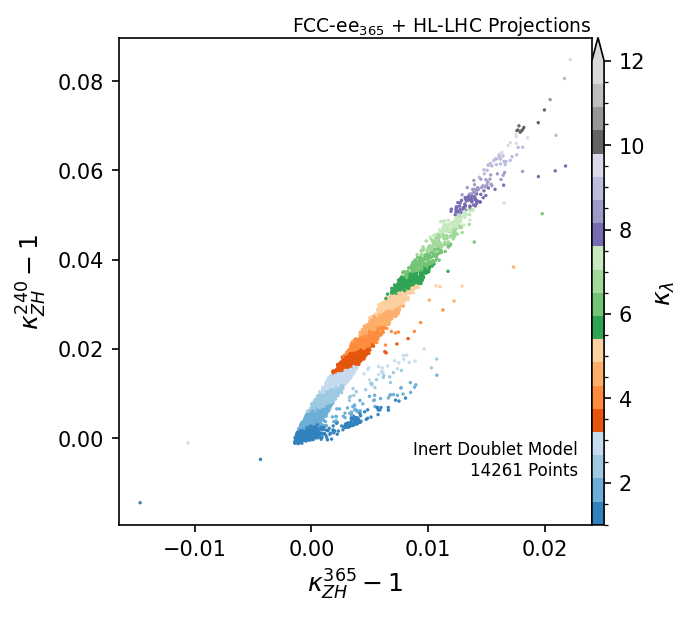

In [ ]:
data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints_2025-01-17",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]
subprocess.run(["mkdir", "-p", "plots/IDM/new_data/"])
plot_dir = "plots/IDM/new_data"
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                )

Processing data files: ['allIDMpoints_2025-01-14', 'data/outlierIDMpoints_2025-01-17', 'data/outlierIDMpoints2_2025-01-17', 'data/outlierIDMpoints3_2025-01-17', 'data/outlierIDMpoints4_2025-01-17']
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048
Number of points satisfying the 5% SM constraint on the single higgs couplings: 44 / 44
Number of points satisfying the 5% SM constraint on the single higgs couplings: 49 / 51
Number of points satisfying the 5% SM constraint on the single higgs couplings: 41 / 50
Number of points satisfying the 5% SM constraint on the single higgs couplings: 55 / 68


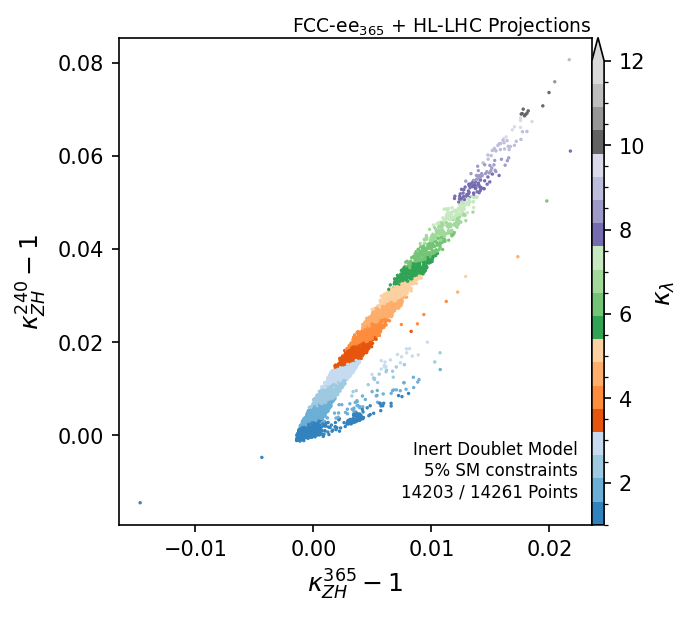

In [304]:
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=BR_constraints
                )

Processing data files: ['allIDMpoints_2025-01-14', 'data/outlierIDMpoints_2025-01-17', 'data/outlierIDMpoints2_2025-01-17', 'data/outlierIDMpoints3_2025-01-17', 'data/outlierIDMpoints4_2025-01-17']
[-5, -5, -4, -4, -3, -3, -2, -2, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10]
{-5: np.float64(0.9279440521594797), -4: np.float64(0.9444042023718197), -3: np.float64(0.9589849320887761), -2: np.float64(0.9717708430928765), -1: np.float64(0.9828319856384048), 0: np.float64(0.9922260435499478), 1: np.float64(1.0), 2: np.float64(1.0061914069885416), 3: np.float64(1.0108293446430638), 4: np.float64(1.0139351308056324), 5: np.float64(1.015522822967809), 6: np.float64(1.0155995408878167), 7: np.float64(1.0141656274647377), 8: np.float64(1.0112146564437785), 9: np.float64(1.0067332873600823), 10: np.float64(1.0007009600012033)}
{-5: np.float64(0.963853672815263), -4: np.float64(0.9739151638320371), -3: np.float64(0.9823142364237928), -2: np.float64(0.9890932417199596)

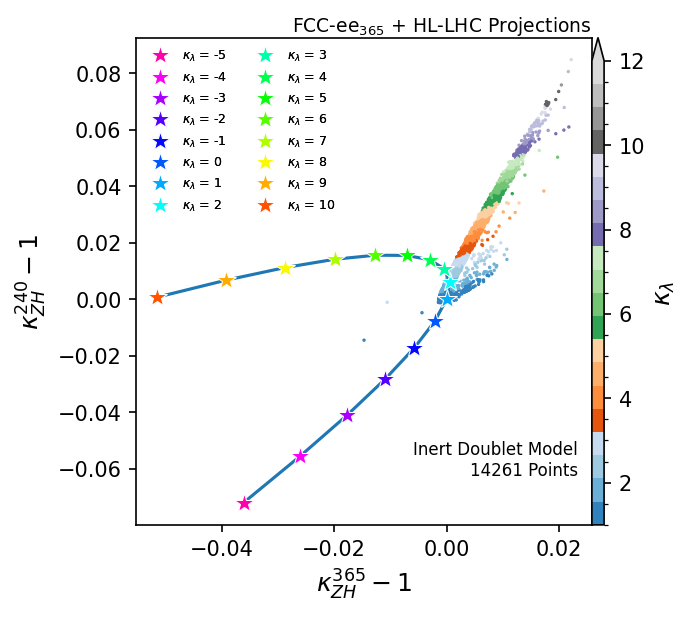

In [305]:
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                        plot_self_consistent_curve=True,
                        plot_name_suffix='_with_self_consistent_curve',
                )

### Datafile 1

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints_2025-01-17']
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048
Number of points satisfying the 5% SM constraint on the single higgs couplings: 44 / 44


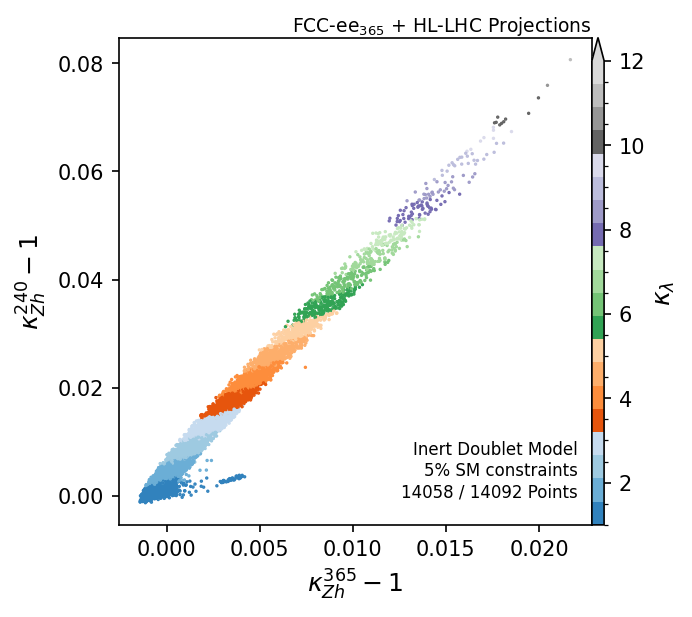

In [74]:
data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints_2025-01-17",
             ]
BR_constraints=0.05
subprocess.run(["mkdir", "-p", "plots/IDM/new_data/"])
plot_dir = "plots/IDM/new_data"
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                )

n_BPs = 0
bp_kappas = {}
bp_EWPOs = {}
bp_model_pars = {}
BP_Names = {}
BP_Names_legend = {}

### Datafile 2

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints2_2025-01-17']
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048
Number of points satisfying the 5% SM constraint on the single higgs couplings: 49 / 51


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

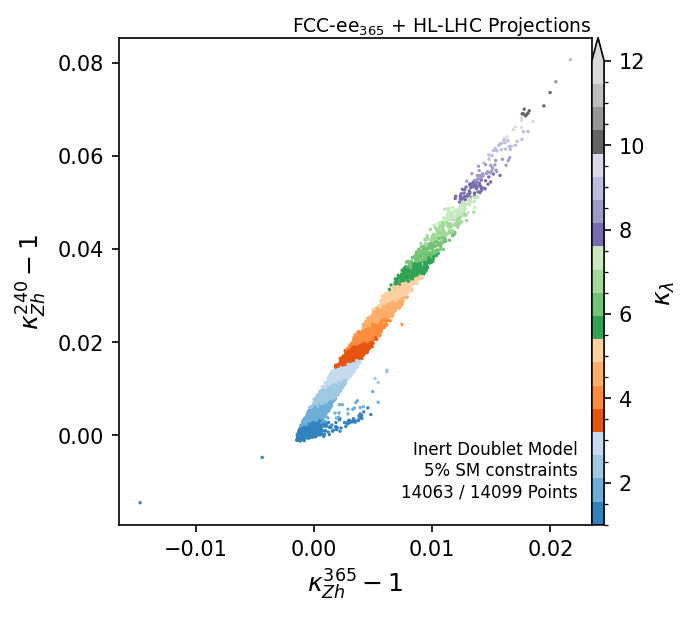

In [75]:
data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             ]
subprocess.run(["mkdir", "-p", "plots/IDM/new_data/"])
plot_dir = "plots/IDM/new_data"
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                )

In [76]:
data_file="data/IDM/outlierIDMpoints2_2025-01-17"
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna()
old_df_indices = df.index.to_numpy()
df = df.reset_index(drop=True)


kappas, EWPOs, model_pars = read_IDM_file(df)


output_dir = "./scan_output/IDM_scan_output"
subprocess.run(["mkdir", "-p", output_dir])

BP_filename = f"{output_dir}/Benchmark_Points_outliers.txt"
with open(BP_filename, "w") as BP_output_file:

    max_errors_365 = [3e-3, 3e-3, 3e-3,]
    max_errors_240 = [3e-3, 3e-3, 3e-3,]
    delta_kappas_z_365 = [-0.005, -0.015, 0.006, ]
    delta_kappas_z_240 = [-0.002, -0.015, 0.015, ]

    BP_Names[data_file] = [f"BP_new_{i}" for i in range(n_BPs, n_BPs+len(delta_kappas_z_240))]
    BP_Names_legend[data_file] = [f"BP new {i}" for i in range(n_BPs, n_BPs+len(delta_kappas_z_240))]

    bp_kappas[data_file], bp_EWPOs[data_file], bp_model_pars[data_file] = find_benchmark(
        df=df,
        kappas=kappas,
        EWPOs=EWPOs,
        old_df_indices=old_df_indices,
        BP_Names=BP_Names[data_file],
        BP_output_file=BP_output_file,
        max_errors_365=max_errors_365,
        max_errors_240=max_errors_240,
        delta_kappas_z_365=delta_kappas_z_365,
        delta_kappas_z_240=delta_kappas_z_240,
        BR_constraints=BR_constraints,
    )
    
n_BPs = n_BPs + len(delta_kappas_z_240)


elif BP == "BP_new_0":
    kappas['uu'] = 0.9869872109932658
    kappas['dd'] = 0.9869872109932658
    kappas['ss'] = 0.9869872109932658
    kappas['cc'] = 0.9869872109932658
    kappas['bb'] = 0.9869872109932658
    kappas['tt'] = 0.9869872109932658
    kappas['ee'] = 0.9869872109932658
    kappas['mumu'] = 0.9869872109932658
    kappas['tautau'] = 0.9869872109932658
    kappas['ZZ_0'] = 0.9927730841276848
    kappas['ZZ_240'] = 0.9952371395622289
    kappas['ZZ_365'] = 0.9956317949997474
    kappas['ZZ_500'] = 0.999337958611399
    kappas['ZZ_550'] = 1.0006435883204592
    kappas['ZZ'] = 0.9896307057302142
    kappas['WW'] = 0.9896307057302142
    kappas['lam'] = 1.251996176990656
    kappas['gamgam'] = 0.9516431530275777
    kappas['Zgam'] = 0.9820251080944254
    # abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = 0.08286101234223403
    # abs(kappas['ZZ_365'] - kappas['ZZ_240']) = 0.0003946554375184874
    Mw = 80.37300109869199
    sin2thetaEff = 0.23140778104452

Processing data files: ['data/IDM/outlierIDMpoints2_2025-01-17', 'data/IDM/allIDMpoints_2025-01-14']
Number of points satisfying the 5% SM constraint on the single higgs couplings: 49 / 51
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

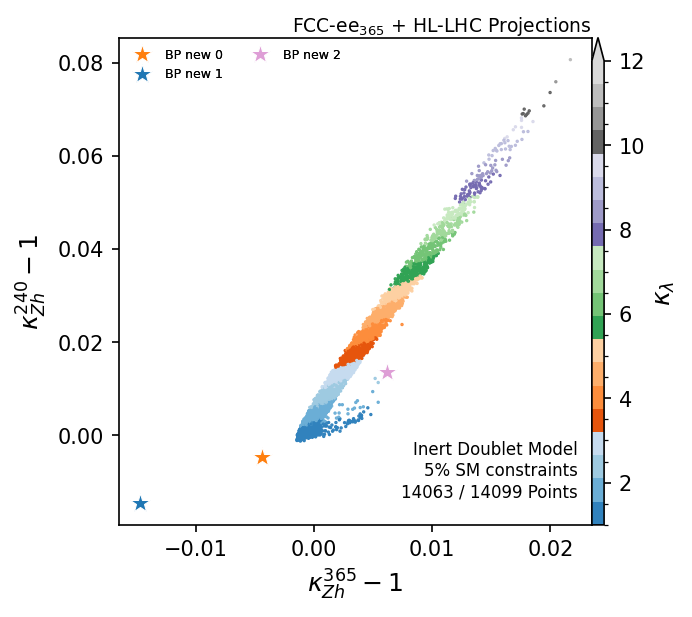

In [77]:
plot_dir = "plots/IDM/new_data"
data_file_plot = [data_file, "data/IDM/allIDMpoints_2025-01-14"]
BR_constraints = 0.05
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, label) for BP, label in zip(bp_kappas[data_file], BP_Names_legend[data_file])]

plot_EffZZH_240_vs_365(data_file_plot, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                       plot_points=plot_points,
                )

### Datafile 3

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints3_2025-01-17']
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048
Number of points satisfying the 5% SM constraint on the single higgs couplings: 41 / 50


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

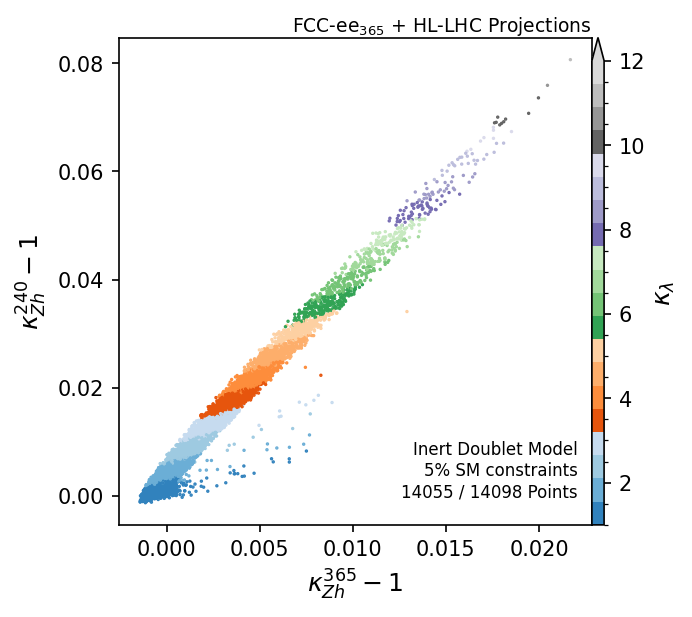

In [78]:
data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             ]
subprocess.run(["mkdir", "-p", "plots/IDM/new_data/"])
plot_dir = "plots/IDM/new_data"
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                )

In [79]:
data_file="data/IDM/outlierIDMpoints3_2025-01-17"
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna()
old_df_indices = df.index.to_numpy()
df = df.reset_index(drop=True)

kappas, EWPOs, model_pars = read_IDM_file(df)


output_dir = "./scan_output/IDM_scan_output"
subprocess.run(["mkdir", "-p", output_dir])

BP_filename = f"{output_dir}/Benchmark_Points_outliers.txt"
with open(BP_filename, "w") as BP_output_file:

    max_errors_365 = [1e-3, 3e-3, 1e-3]
    max_errors_240 = [1e-3, 3e-3, 1e-3, ]
    delta_kappas_z_365 = [0.0095, 0.0125, 0.0075]
    delta_kappas_z_240 = [0.017, 0.033, 0.008]

    BP_Names[data_file] = [f"BP_new_{i}" for i in range(n_BPs, n_BPs+len(delta_kappas_z_240))]
    BP_Names_legend[data_file] = [f"BP new {i}" for i in range(n_BPs, n_BPs+len(delta_kappas_z_240))]

    bp_kappas[data_file], bp_EWPOs[data_file], bp_model_pars[data_file] = find_benchmark(
        df=df,
        kappas=kappas,
        EWPOs=EWPOs,
        old_df_indices=old_df_indices,
        BP_Names=BP_Names[data_file],
        BP_output_file=BP_output_file,
        max_errors_365=max_errors_365,
        max_errors_240=max_errors_240,
        delta_kappas_z_365=delta_kappas_z_365,
        delta_kappas_z_240=delta_kappas_z_240,
        BR_constraints=BR_constraints,
    )
    
n_BPs = n_BPs + len(delta_kappas_z_240)


elif BP == "BP_new_3":
    kappas['uu'] = 0.9881747344745595
    kappas['dd'] = 0.9881747344745595
    kappas['ss'] = 0.9881747344745595
    kappas['cc'] = 0.9881747344745595
    kappas['bb'] = 0.9881747344745595
    kappas['tt'] = 0.9881747344745595
    kappas['ee'] = 0.9881747344745595
    kappas['mumu'] = 0.9881747344745595
    kappas['tautau'] = 0.9881747344745595
    kappas['ZZ_0'] = 1.0074114610219205
    kappas['ZZ_240'] = 1.0172598666184485
    kappas['ZZ_365'] = 1.0088851116279154
    kappas['ZZ_500'] = 1.0076338585646742
    kappas['ZZ_550'] = 1.008095595249646
    kappas['ZZ'] = 0.9956228983887574
    kappas['WW'] = 0.9956228983887574
    kappas['lam'] = 2.702656543464968
    kappas['gamgam'] = 0.9510241156863131
    kappas['Zgam'] = 0.981841354476324
    # abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = 0.48521551038995864
    # abs(kappas['ZZ_365'] - kappas['ZZ_240']) = 0.008374754990533084
    Mw = 80.37100942625534
    sin2thetaEff = 0.2314176589787162

Processing data files: ['data/IDM/outlierIDMpoints3_2025-01-17', 'data/IDM/allIDMpoints_2025-01-14']
Number of points satisfying the 5% SM constraint on the single higgs couplings: 41 / 50
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

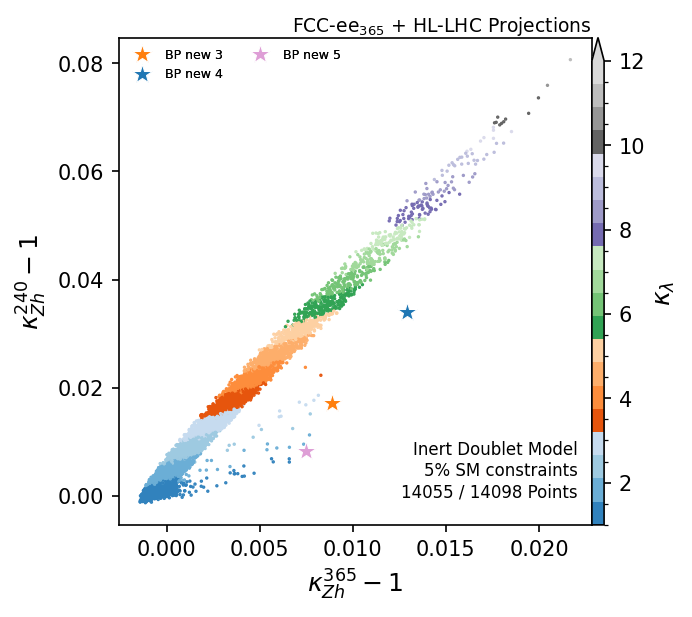

In [80]:
plot_dir = "plots/IDM/new_data"
data_file_plot = [data_file, "data/IDM/allIDMpoints_2025-01-14"]
BR_constraints = 0.05
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, label) for BP, label in zip(bp_kappas[data_file], BP_Names_legend[data_file])]

plot_EffZZH_240_vs_365(data_file_plot, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                       plot_points=plot_points,
                )

### Datafile 4

Processing data files: ['data/IDM/allIDMpoints_2025-01-14', 'data/IDM/outlierIDMpoints4_2025-01-17']
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048
Number of points satisfying the 5% SM constraint on the single higgs couplings: 55 / 68


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

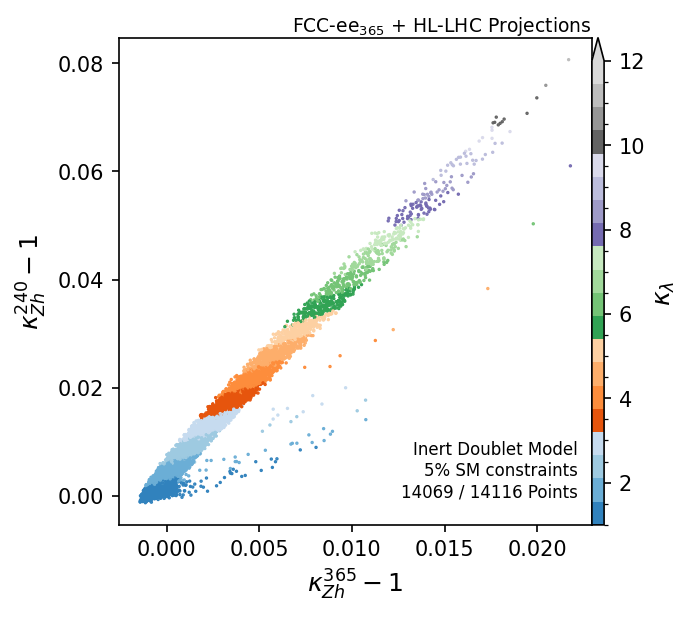

In [81]:
data_file = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]
subprocess.run(["mkdir", "-p", "plots/IDM/new_data/"])
plot_dir = "plots/IDM/new_data"
BR_constraints = 0.05
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                )

In [83]:
data_file="data/IDM/outlierIDMpoints4_2025-01-17"
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna()
old_df_indices = df.index.to_numpy()
df = df.reset_index(drop=True)

kappas, EWPOs, model_pars = read_IDM_file(df)


output_dir = "./scan_output/IDM_scan_output"
subprocess.run(["mkdir", "-p", output_dir])

BP_filename = f"{output_dir}/Benchmark_Points_outliers.txt"
with open(BP_filename, "w") as BP_output_file:

    max_errors_365 = [5e-3, 3e-3, 1e-3, 1e-3, 2e-3,]
    max_errors_240 = [5e-3, 3e-3, 1e-3, 1e-3, 2e-3,]
    delta_kappas_z_365 = [0.017, 0.020, 0.022, 0.011, 0.011,]
    delta_kappas_z_240 = [0.040, 0.050, 0.061, 0.018, 0.030,]

    BP_Names[data_file] = [f"BP_new_{i}" for i in range(n_BPs, n_BPs+len(delta_kappas_z_240))]
    BP_Names_legend[data_file] = [f"BP new {i}" for i in range(n_BPs, n_BPs+len(delta_kappas_z_240))]

    bp_kappas[data_file], bp_EWPOs[data_file], bp_model_pars[data_file] = find_benchmark(
        df=df,
        kappas=kappas,
        EWPOs=EWPOs,
        old_df_indices=old_df_indices,
        BP_Names=BP_Names[data_file],
        BP_output_file=BP_output_file,
        max_errors_365=max_errors_365,
        max_errors_240=max_errors_240,
        delta_kappas_z_365=delta_kappas_z_365,
        delta_kappas_z_240=delta_kappas_z_240,
        BR_constraints=BR_constraints,
    )
    
n_BPs = n_BPs + len(delta_kappas_z_240)


elif BP == "BP_new_6":
    kappas['uu'] = 0.9834419885721146
    kappas['dd'] = 0.9834419885721146
    kappas['ss'] = 0.9834419885721146
    kappas['cc'] = 0.9834419885721146
    kappas['bb'] = 0.9834419885721146
    kappas['tt'] = 0.9834419885721146
    kappas['ee'] = 0.9834419885721146
    kappas['mumu'] = 0.9834419885721146
    kappas['tautau'] = 0.9834419885721146
    kappas['ZZ_0'] = 1.017625243299268
    kappas['ZZ_240'] = 1.0383293329401886
    kappas['ZZ_365'] = 1.017328563064984
    kappas['ZZ_500'] = 1.0106365761100995
    kappas['ZZ_550'] = 1.0095652870157676
    kappas['ZZ'] = 0.9948095676884501
    kappas['WW'] = 0.9948095676884501
    kappas['lam'] = 4.836238671915516
    kappas['gamgam'] = 0.9508797089917917
    kappas['Zgam'] = 0.9817993759028473
    # abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = 0.5479033488001338
    # abs(kappas['ZZ_365'] - kappas['ZZ_240']) = 0.021000769875204606
    Mw = 80.37965470044583
    sin2thetaEff = 0.2313706760453281


Processing data files: ['data/IDM/outlierIDMpoints4_2025-01-17', 'data/IDM/allIDMpoints_2025-01-14']
Number of points satisfying the 5% SM constraint on the single higgs couplings: 55 / 68
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

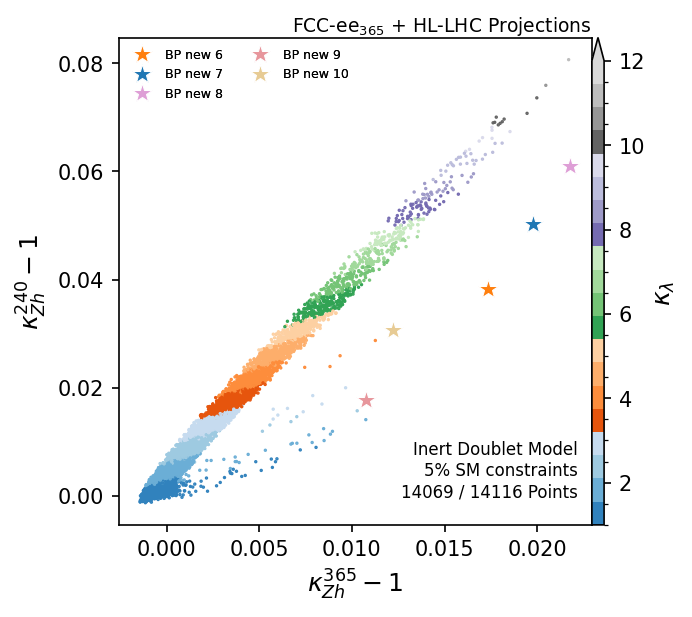

In [84]:
plot_dir = "plots/IDM/new_data"
data_file_plot = [data_file, "data/IDM/allIDMpoints_2025-01-14"]
BR_constraints = 0.05
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, label) for BP, label in zip(bp_kappas[data_file], BP_Names_legend[data_file])]

plot_EffZZH_240_vs_365(data_file_plot, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                       plot_points=plot_points,
                )

### Print all points

Processing data files: ['data/IDM/outlierIDMpoints4_2025-01-17', 'data/IDM/allIDMpoints_2025-01-14']
Number of points satisfying the 5% SM constraint on the single higgs couplings: 55 / 68
Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


(<Figure size 675x600 with 2 Axes>,
 <Axes: xlabel='$\\kappa_{Zh}^{365} - 1$', ylabel='$\\kappa_{Zh}^{240} - 1$'>)

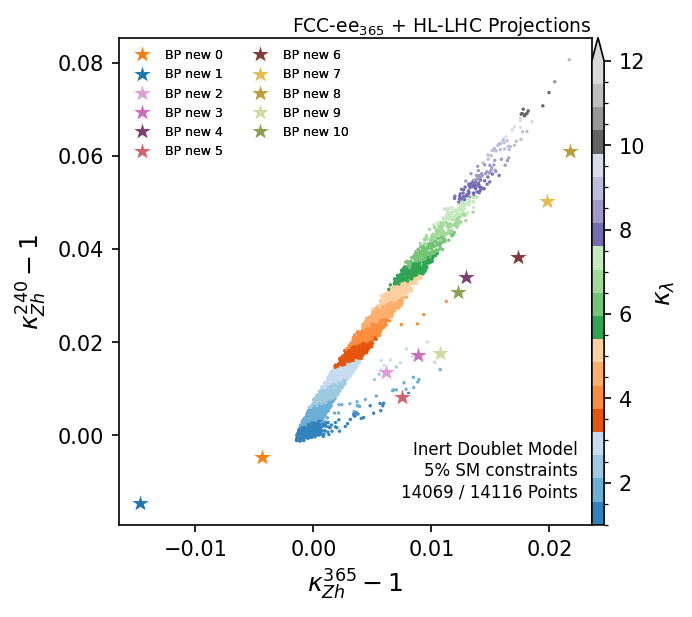

In [85]:
BR_constraints = 0.05
plot_dir = "plots/IDM/new_data"
data_files = [
             # "data/IDM/outlierIDMpoints_2025-01-17",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]

data_files_plot = ["data/IDM/allIDMpoints_2025-01-14",
             "data/IDM/outlierIDMpoints_2025-01-17",
             "data/IDM/outlierIDMpoints2_2025-01-17",
             "data/IDM/outlierIDMpoints3_2025-01-17",
             "data/IDM/outlierIDMpoints4_2025-01-17",
             ]


plot_points = []

for file in data_files:
    for BP, label in zip(bp_kappas[file], BP_Names_legend[file]):
       plot_points.append((BP["ZZ_365"]-1, BP["ZZ_240"]-1, label))

plot_EffZZH_240_vs_365(data_file_plot, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                       plot_points=plot_points,
                       plot_name_suffix="_new_BPs"
                )

### Test without momentum-dependent 1L BSM constributions

In [97]:
def read_IDM_file_no_1L_BSM(df, loop_order=1):

    kappas = {}
    EWPOs = {}

    for fermion in ['uu', 'dd', 'ss', 'cc', 'bb', 'tt', 'ee', 'mumu', 'tautau']:
        kappas[fermion] = df['dkappaf'] + 1

    # kappas['gg'] = df['dkappaf'] + 1

    kappas['ZZ_0'] = df['effZZh1L_s0'] + df['effZZh1Lkala_s0'] + 1
    # kappas['ZZ_125'] = df['effZZh1L_s125'] + df['effZZh1Lkala_s125'] + 1
    kappas['ZZ_240'] = df['effZZh1L_s240'] + df['effZZh1Lkala_s240'] + 1
    kappas['ZZ_365'] = df['effZZh1L_s365'] + df['effZZh1Lkala_s365'] + 1
    kappas['ZZ_500'] = df['effZZh1L_s500'] + df['effZZh1Lkala_s500'] + 1
    kappas['ZZ_550'] = df['effZZh1L_s550'] + df['effZZh1Lkala_s550'] + 1
    
    # Excluding the momentum dependence of the BSM k_Zh coupling
    kappas['ZZ_0_no_1L_BSM_sqrt_s'] = df['dghZZ1L'] + df['effZZh1Lkala_s0'] + 1
    # kappas['ZZ_125_no_1L_BSM_sqrt_s'] = df['dghZZ1L'] + df['effZZh1Lkala_s125'] + 1
    kappas['ZZ_240_no_1L_BSM_sqrt_s'] = df['dghZZ1L'] + df['effZZh1Lkala_s240'] + 1
    kappas['ZZ_365_no_1L_BSM_sqrt_s'] = df['dghZZ1L'] + df['effZZh1Lkala_s365'] + 1
    kappas['ZZ_500_no_1L_BSM_sqrt_s'] = df['dghZZ1L'] + df['effZZh1Lkala_s500'] + 1
    kappas['ZZ_550_no_1L_BSM_sqrt_s'] = df['dghZZ1L'] + df['effZZh1Lkala_s550'] + 1

    # Excluding the full BSM contribution to the k_Zh coupling
    kappas['ZZ_0_no_1L_BSM'] = df['effZZh1Lkala_s0'] + 1
    # kappas['ZZ_125_no_1L_BSM'] = df['effZZh1Lkala_s125'] + 1
    kappas['ZZ_240_no_1L_BSM'] = df['effZZh1Lkala_s240'] + 1
    kappas['ZZ_365_no_1L_BSM'] = df['effZZh1Lkala_s365'] + 1
    kappas['ZZ_500_no_1L_BSM'] = df['effZZh1Lkala_s500'] + 1
    kappas['ZZ_550_no_1L_BSM'] = df['effZZh1Lkala_s550'] + 1

    kappas['ZZ'] = df['dghZZ1L'] + 1
    kappas['WW'] = kappas['ZZ']


    if loop_order==1:
        kappas["lam"] = df['kalam1L']

        kappas['gamgam'] = np.sqrt(df['DeltaGammagamgam1L'] + 1)
        kappas['Zgam'] = np.sqrt(df['DeltaGammaZgam1L'] + 1)

        EWPOs['Mw'] = df['MW1L']
        EWPOs['sin2thetaEff'] = df['sl1L']
        EWPOs['GammaZ'] = df['GamZ1L']

    elif loop_order==2:
        kappas["lam"] = df['kalam2LDI']

        kappas['gamgam'] = np.sqrt(df['DeltaGammagamgam2LDI'] + 1)
        kappas['Zgam'] = np.sqrt(df['DeltaGammaZgam1L'] + 1)

        EWPOs['Mw'] = df['MW2L']
        EWPOs['sin2thetaEff'] = df['sl2L']
        EWPOs['GammaZ'] = df['GamZ2L']

    else:
        raise ValueError("Wrong loop order argument!")


    model_pars = {}

    for par in ["mu2sq", "lam1", "lam2", "lam3", "lam4", "lam5", "mH", "mA", "mHp"]:
        model_pars[par] = df[par]

    return kappas, EWPOs, model_pars


In [ ]:
BR_constraints=0.05
data_file="data/IDM/allIDMpoints_2025-01-14"
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna()
old_df_indices = df.index.to_numpy()
df = df.reset_index(drop=True)

kappas, EWPOs, model_pars = read_IDM_file_no_1L_BSM(df)

def print_to_file(message, file):
    print(message)
    print(message, file=file)


output_dir = "./scan_output/IDM_scan_output"
subprocess.run(["mkdir", "-p", output_dir])

BP_filename = f"{output_dir}/Benchmark_Points_outliers.txt"
BR_constraint=0.05
with open(BP_filename, "w") as BP_output_file:

    max_errors_365 = [1e-3, 1e-3, 1e-3, 1e-3, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 4e-4, 4e-4, 4e-4]
    max_errors_240 = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 2e-3, 2e-3, 2e-3]
    delta_kappas_z_365 = [0.0075, 0.004, -0.0024, 0.001, 0.0001, 0.0024, 0.0017, 0.0046, 0.0040, 0.0068, 0.0063, 0.0092, 0.0086, 0.0116, 0.011, 0.0140, 0.0140, 0.0165, 0.0164, 0.0195, 0.022]
    delta_kappas_z_240 = [0.023, 0.004, -0.0020, -0.0005, 0.008, 0.009, 0.016, 0.017, 0.0225, 0.025, 0.0325, 0.033, 0.040, 0.041, 0.049, 0.051, 0.058, 0.060, 0.066, 0.071, 0.08]



    BP_Names = ["BPO_0", "BPO_1"]
    BP_Names = BP_Names + [f"BPB_{i}" for i in range(len(delta_kappas_z_240)-2)]
    BP_Names_legend = ["BPO 0", "BPO 1"]
    BP_Names_legend = BP_Names_legend + [f"BPB {i}" for i in range(len(delta_kappas_z_240)-2)]

    bp_kappas , bp_EWPOs, bp_model_pars = find_benchmark(
        df=df,
        EWPOs=EWPOs,
        kappas=kappas,
        old_df_indices=old_df_indices,
        BP_Names=BP_Names,
        BP_output_file=BP_output_file,
        max_errors_365=max_errors_365,
        max_errors_240=max_errors_240,
        delta_kappas_z_365=delta_kappas_z_365,
        delta_kappas_z_240=delta_kappas_z_240,
        BR_constraints=BR_constraints,
    )


elif BP == "BPO_0":
    kappas['uu'] = 0.9818547810617284
    kappas['dd'] = 0.9818547810617284
    kappas['ss'] = 0.9818547810617284
    kappas['cc'] = 0.9818547810617284
    kappas['bb'] = 0.9818547810617284
    kappas['tt'] = 0.9818547810617284
    kappas['ee'] = 0.9818547810617284
    kappas['mumu'] = 0.9818547810617284
    kappas['tautau'] = 0.9818547810617284
    kappas['ZZ_0'] = 1.007141704579298
    kappas['ZZ_240'] = 1.0237693288776533
    kappas['ZZ_365'] = 1.0074536101415776
    kappas['ZZ_500'] = 1.0026988104523176
    kappas['ZZ_550'] = 1.0021232678597285
    kappas['ZZ_0_no_1L_BSM_sqrt_s'] = 1.0023378651272847
    kappas['ZZ_240_no_1L_BSM_sqrt_s'] = 1.0177981665211153
    kappas['ZZ_365_no_1L_BSM_sqrt_s'] = 0.9998722462932628
    kappas['ZZ_500_no_1L_BSM_sqrt_s'] = 0.9924197633264032
    kappas['ZZ_550_no_1L_BSM_sqrt_s'] = 0.9905262353724729
    kappas['ZZ_0_no_1L_BSM'] = 1.0123986410355819
    kappas['ZZ_240_no_1L_BSM'] = 1.0278589424294124
    kappas['ZZ_365_no_1L_BSM'

## Finding BP with $\kappa_\lambda \approx 1$

In [110]:
def find_benchmark_lambda1(df,
                           kappas,
                           EWPOs,
                           old_df_indices,
                           BP_Name,
                        #    max_delta_lambda,
                           BR_constraints=None,
                           ):

    n_pts = df.shape[0]

    if not BR_constraints is None:
        satisfy_BR_constraint = [True for i in range(n_pts)]
        for i in range(n_pts):
            for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam']:
                if np.abs(kappas[coup][i] - 1.) > BR_constraints:
                    satisfy_BR_constraint[i] = False

        for coup in kappas.keys():
            kappas[coup] = np.array(kappas[coup][satisfy_BR_constraint])
        
        for ewpo in EWPOs.keys():
            EWPOs[ewpo] = np.array(EWPOs[ewpo][satisfy_BR_constraint])

        for par in model_pars.keys():
            model_pars[par] = np.array(model_pars[par][satisfy_BR_constraint])

        old_df_indices = old_df_indices[satisfy_BR_constraint]

    bp_index = None
    bp_kappas = None
    bp_EWPOs = None
    bp_model_pars = None

    # for ind, lmbd in enumerate(kappas['lam']):
    #     if abs(lmbd-1) < max_delta_lambda:
    #         bp_index = ind

    bp_index = np.argmin(kappas['lam'])


    if bp_index is None:
        raise ValueError(f"Could not find such BP!")


    print(f"\nelif BP == \"{BP_Name}\":")

    bp_kappas = {coup:kps[bp_index] for (coup, kps) in kappas.items()}
    bp_EWPOs = {obs_name:obs_value[bp_index] for (obs_name, obs_value) in EWPOs.items()}
    bp_model_pars = {par_name:par_value[bp_index] for (par_name, par_value) in model_pars.items()}

    for coup, kaps in bp_kappas.items():
        print(f"    kappas['{coup}'] = {kaps}")

    for obs_name, obs_value in bp_EWPOs.items():
        print(f"    {obs_name} = {obs_value}")

    for par_name, par_value in bp_model_pars.items():
        print(f"    # {par_name} = {par_value}")

    print(f"    # Best scan point row: {old_df_indices[bp_index]+2} out of {old_df_indices[-1]+2}")

        
    return bp_kappas, bp_EWPOs, bp_model_pars

In [112]:
# max_delta_lambda = 0.1

BR_constraints=0.05
data_file="data/IDM/allIDMpoints_2025-01-14"
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna()
old_df_indices = df.index.to_numpy()
df = df.reset_index(drop=True)

kappas, EWPOs, model_pars = read_IDM_file_no_1L_BSM(df)

output_dir = "./scan_output/IDM_scan_output"
subprocess.run(["mkdir", "-p", output_dir])

BP_filename = f"{output_dir}/Benchmark_Points_outliers.txt"
BR_constraint=0.05

BP_Name = "BP_lambda1"

bp_kappas , bp_EWPOs, bp_model_pars = find_benchmark_lambda1(
    df=df,
    kappas=kappas,
    EWPOs=EWPOs,
    old_df_indices=old_df_indices,
    BP_Name=BP_Name,
    # max_delta_lambda=max_delta_lambda,
    BR_constraints=BR_constraints,
)


elif BP == "BP_lambda1":
    kappas['uu'] = 0.9984178113049657
    kappas['dd'] = 0.9984178113049657
    kappas['ss'] = 0.9984178113049657
    kappas['cc'] = 0.9984178113049657
    kappas['bb'] = 0.9984178113049657
    kappas['tt'] = 0.9984178113049657
    kappas['ee'] = 0.9984178113049657
    kappas['mumu'] = 0.9984178113049657
    kappas['tautau'] = 0.9984178113049657
    kappas['ZZ_0'] = 0.9991982973881574
    kappas['ZZ_240'] = 0.9998186516447237
    kappas['ZZ_365'] = 0.999375887226692
    kappas['ZZ_500'] = 0.9993603116685574
    kappas['ZZ_550'] = 0.9994021868768549
    kappas['ZZ_0_no_1L_BSM_sqrt_s'] = 0.9987890035121672
    kappas['ZZ_240_no_1L_BSM_sqrt_s'] = 0.9992979176548258
    kappas['ZZ_365_no_1L_BSM_sqrt_s'] = 0.9987078415565833
    kappas['ZZ_500_no_1L_BSM_sqrt_s'] = 0.9984625246068588
    kappas['ZZ_550_no_1L_BSM_sqrt_s'] = 0.9984001944406656
    kappas['ZZ_0_no_1L_BSM'] = 1.0004081320028646
    kappas['ZZ_240_no_1L_BSM'] = 1.0009170461455232
    kappas['ZZ_365_no_1L

# Old code

In [33]:
full=True
datafile="data/IDM/allIDMpoints_2025-01-05"
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna().reset_index(drop=True)

kappas, EWPOs, model_pars = read_IDM_file(df)

n_pts = df.shape[0]
chisq = np.full((n_pts,), np.nan)
for ind in range(n_pts):
    kappas_row = {coup:kps[ind] for (coup, kps) in kappas.items()}
    chisq[ind] = getChisq(kappas_row, signals)

if any(np.isnan(chisq)): raise ValueError('Wrong chisq!')
    
for ind, lam in enumerate(kappas['lam']):
    if lam < min_lambda: chisq[ind]=1e30

bfp_index = np.argmin(chisq)
bfp_chisq = np.min(chisq)
bfp_kappas = {coup:kps[bfp_index] for (coup, kps) in kappas.items()}
bfp_EWPOs = {obs_name:obs_value[bfp_index] for (obs_name, obs_value) in EWPOs.items()}

for coup, kaps in bfp_kappas.items():
    print(f"kappas['{coup}'] = {kaps}")
    # print(f"kappa_[{coup}] - 1 = {kaps-1}")

for obs_name, obs_value in bfp_EWPOs.items():
    print(f"{obs_name} = {obs_value}")

# print(f"Best scan point: (k_Lamb = {bfp_kappas['lam']:.10g}, (1 - k_Z ) = {1 - bfp_kappas['ZZ']:.10g}), with chisq = {bfp_chisq:.3g}")
print(f"Best scan point row: {bfp_index+2} out of {len(chisq)+2}")

TypeError: can only concatenate list (not "str") to list

### Plotting this point

In [ ]:
plot_IDM_bounds(data_file, plot_dir, signals, plot_point=(bfp_kappas['lam'], bfp_kappas['ZZ']-1))

: 

In [ ]:
plot_IDM_bounds(data_file, plot_dir, signals, zoom=True, 
                plot_point=(bfp_kappas['lam'], bfp_kappas['ZZ']-1),
                zoom_range_x=(1.0, 3.0), zoom_range_y=(0.00, 0.005))

: 

### Similar, but minimizing $|\kappa_Z-1|$ instead of $\chi^2$

In [ ]:
full=True
datafile="data/IDM/allIDMpoints_2025-01-05"
min_lambda = 1.85
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna().reset_index(drop=True)

kappas, EWPOs, model_pars = read_IDM_file(df)

n_pts = df.shape[0]
for ind in range(n_pts):
    kappas_row = {coup:kps[ind] for (coup, kps) in kappas.items()}
    
dkappa_Z = np.abs(kappas['ZZ'] - 1)

for ind, lam in enumerate(kappas['lam']):
    if lam < min_lambda: dkappa_Z[ind]=1e30

bfp_index = np.argmin(dkappa_Z)
bfp_dkappa_Z = np.min(dkappa_Z)
bfp_kappas = {coup:kps[bfp_index] for (coup, kps) in kappas.items()}
bfp_EWPOs = {obs_name:obs_value[bfp_index] for (obs_name, obs_value) in EWPOs.items()}


for coup, kaps in bfp_kappas.items():
    if coup=='lam':
        print(f"kappa_{coup} = {kaps}")
    else:
        print(f"kappa_{coup} - 1 = {kaps-1}")

for obs_name, obs_value in bfp_EWPOs.items():
    print(f"{obs_name} = {obs_value}")

# print(f"Best scan point: (k_Lamb = {bfp_kappas['lam']:.10g}, (1 - k_Z ) = {1 - bfp_kappas['ZZ']:.10g}), with chisq = {bfp_chisq:.3g}")
print(f"Best scan point row: {bfp_index+2} out of {len(chisq)+2}")

kappa_uu - 1 = -0.010689823291017753
kappa_dd - 1 = -0.010689823291017753
kappa_ss - 1 = -0.010689823291017753
kappa_cc - 1 = -0.010689823291017753
kappa_bb - 1 = -0.010689823291017753
kappa_tt - 1 = -0.010689823291017753
kappa_ee - 1 = -0.010689823291017753
kappa_mumu - 1 = -0.010689823291017753
kappa_tautau - 1 = -0.010689823291017753
kappa_ZZ_125 - 1 = -0.0017643393067441338
kappa_ZZ_240 - 1 = 0.0035032895302309353
kappa_ZZ_365 - 1 = -0.0004441288326013648
kappa_ZZ - 1 = 0.0035032895302309353
kappa_WW - 1 = 0.0035032895302309353
kappa_lam = 2.010521894355323
kappa_gamgam - 1 = -0.051645962583108385
kappa_Zgam - 1 = -0.01916278387156345
Mw = 80.38196018098455
sin2thetaEff = 0.2313584995560495
GammaZ = 2.4955795303607173
Best scan point row: 7122 out of 14050


: 

#### Changing the likelihood

In [ ]:
# os.chdir("/cephfs/user/mrebuzzi/phd/HiggsTools/future_projections")


def modify_kappa_central_values(kappas):
    
    os.system("mkdir modified_measurements")
    os.system("cp -r hsdataset/* modified_measurements/")
    os.chdir("modified_measurements/h125")
    os.system("rm EffLamHL-LHC_LHC13_LHCComb_6000.json")
    os.system("rm EffCouplings_FCCee365_FCCeeComb_1500.json")

    bins = {
        "effWW": {
            "coupling": "effWW",
            "obsCoupling": [kappas["WW"] - 0.41/100., kappas["WW"], kappas["WW"] + 0.41/100.],
            "process": {"channels": [[p, "WW"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effZZ": {
            "coupling": "effZZ",
            "obsCoupling": [kappas["ZZ"] - 0.17/100., kappas["ZZ"], kappas["ZZ"] + 0.17/100.],
            "process": {"channels": [[p, "ZZ"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effgg": {
            "coupling": "effgg",
            "obsCoupling": [kappas["gg"] - 0.9/100., kappas["gg"], kappas["gg"] + 0.9/100.],
            "process": {"channels": [[p, "gg"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effgamgam": {
            "coupling": "effgamgam",
            "obsCoupling": [kappas["gamgam"] - 1.3/100., kappas["gamgam"], kappas["gamgam"] + 1.3/100.],
            "process": {"channels": [[p, "gamgam"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effZgam": {
            "coupling": "effZgam",
            "obsCoupling": [kappas["Zgam"] - 10/100., kappas["Zgam"], kappas["Zgam"] + 10/100.],
            "process": {"channels": [[p, "Zgam"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effcc": {
            "coupling": "effcc",
            "obsCoupling": [kappas["cc"] - 1.3/100., kappas["cc"], kappas["cc"] + 1.3/100.],
            "process": {"channels": [[p, "cc"] for p in ("eeHZ", "eeHnunu")]},
        },
        "efftt": {
            "coupling": "efftt",
            "obsCoupling": [kappas["tt"] - 3.1/100., kappas["tt"], kappas["tt"] + 3.1/100.],
            "process": {"channels": [[p, "bb"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effbb": {
            "coupling": "effbb",
            "obsCoupling": [kappas["bb"] - 0.64/100., kappas["bb"], kappas["bb"] + 0.64/100.],
            "process": {"channels": [[p, "bb"] for p in ("eeHZ", "eeHnunu")]},
        },
        "effmumu": {
            "coupling": "effmumu",
            "obsCoupling": [kappas["mumu"] - 3.9/100., kappas["mumu"], kappas["mumu"] + 3.9/100.],
            "process": {"channels": [[p, "mumu"] for p in ("eeHZ", "eeHnunu")]},
        },
        "efftautau": {
            "coupling": "efftautau",
            "obsCoupling": [kappas["tautau"] - 0.66/100., kappas["tautau"], kappas["tautau"] + 0.66/100.],
            "process": {"channels": [[p, "tautau"] for p in ("eeHZ", "eeHnunu")]},
        },
    }


    # Read correlation matrix from CSV file obtained from Fig. 14 through graphreader:
    corrMat = pd.DataFrame(
        index=bins.keys(), columns=bins.keys(), data=np.identity(len(bins))
    )

    corr_path = "EffCouplings_FCCee365_FCCeeComb_1500_correlations.csv"
    measurement_list = list(bins.keys())
    df = pd.read_csv(corr_path, usecols=range(len(measurement_list)), skipfooter=1)
    for i, r in df.iterrows():
        for j in range(i+1, len(df.columns)):
            corrMat.loc[measurement_list[i], measurement_list[j]] = r[str(j)]

    # print(corrMat)

    measFile = implementMeasurement(
        "1905.03764",
        "Tab. 5, Fig. 14",
        bins,
        corrMatExp=corrMat,
        prefix="EffCouplings",
        referenceMass=125.38,
        massResolution=0.15 * 125,  # Change!
        experiment="FCCeeComb",
        collider="FCCee365",
        luminosity=1500
    )

    os.chdir("../..")

: 

/jwd/tmp/ipykernel_1721/939526508.py:73: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(corr_path, usecols=range(len(measurement_list)), skipfooter=1)


Could not detect experiment
Looks good. Saving this to EffCouplings_FCCee365_FCCeeComb_1500.json
9
[np.float64(10.423363154355838), np.float64(17.21182898078949), np.float64(25.25686586179292)]
Best scan point: (k_Lamb = 1.279935964, (1 - k_Z ) = 0.002797079738), with chisq = -2.18e-05
Best scan point row: 198400 out of 203144
Best scan point model parameters: muS=487.04140136524177, lamS=4.339488870720752, lamSH=8.086139566881284
0.050925970701378165
Standard Model Chi2 value for kappa central values (k_Lamb = 1.801875586, (1 - k_Z ) = 0.002789967621): 3.344181119



/jwd/tmp/ipykernel_1721/939526508.py:73: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(corr_path, usecols=range(len(measurement_list)), skipfooter=1)


Could not detect experiment
Looks good. Saving this to EffCouplings_FCCee365_FCCeeComb_1500.json
9
[np.float64(10.423363154355838), np.float64(17.21182898078949), np.float64(25.25686586179292)]
Best scan point: (k_Lamb = 2.081304908, (1 - k_Z ) = 0.004232635842), with chisq = -2.26e-05
Best scan point row: 117951 out of 203144
Best scan point model parameters: muS=1149.7002499691434, lamS=7.948824580908525, lamSH=17.282034165448867
0.43292897330484803
Standard Model Chi2 value for kappa central values (k_Lamb = 2.482538926, (1 - k_Z ) = 0.004239875933): 7.67626483



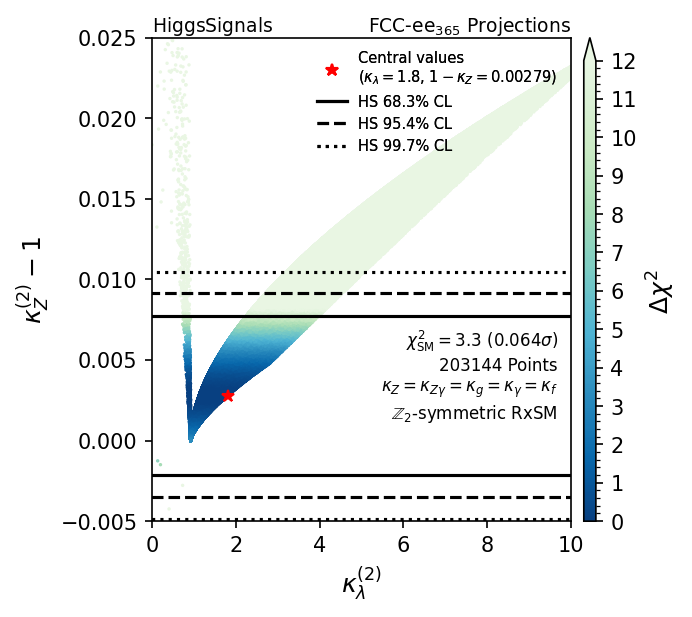

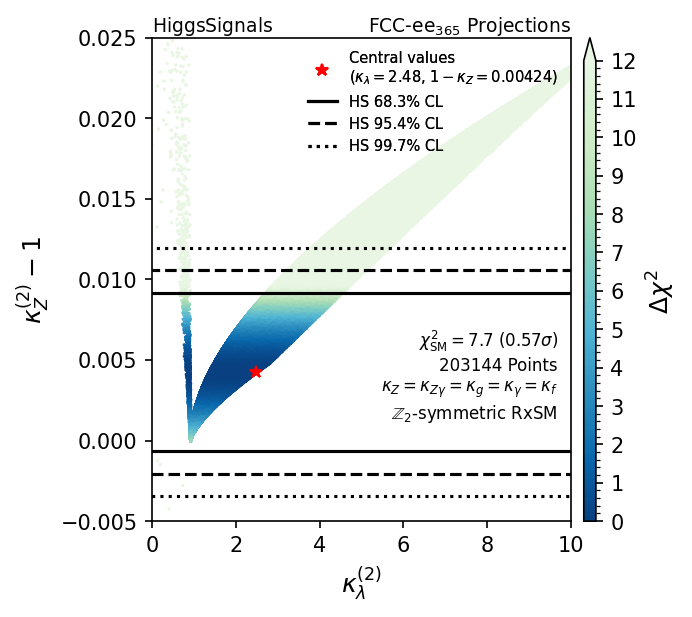

: 

In [ ]:
data_file = "data/IDM/allIDMpoints_2025-01-05"
plot_dir = "plots"
points = [(1.801875586, 1 - 0.002789967621), (2.482538926, 1 - 0.004239875933)]
ndof = 10 - 1
# ndof = 1

kappas_list = {}
for point in points:
    kappas = dict()
    for kappa in ['WW', 'ZZ', 'gg', 'gamgam', 'Zgam', 'cc', 'tt', 'bb', 'mumu', 'tautau']:
        kappas[kappa] = point[1]
    kappas_list[point] = kappas

for point in points:
# for k_lambda_exp_error in [0.5]:
    pred = HP.Predictions()
    modify_kappa_central_values(kappas_list[point])

    # bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
    signals_mod = HS.Signals('modified_measurements') # load HS dataset

    h = pred.addParticle(HP.NeutralScalar("h", "even"))
    h.setMass(125)

    plot_IDM_bounds(data_file, plot_dir, signals_mod, modified_central=point, 
                        ndof=ndof, full=True, zoom=True, zoom_range_x=(0, 10), zoom_range_y=(-0.005, 0.025))

    chisq_true = getChisq(*point, np.inf, signals_mod)
    chisq_SM = getChisq(1, 1, np.inf, signals_mod) - chisq_true
    print(f"Standard Model Chi2 value for kappa central values (k_Lamb = {point[0]:.10g}, (1 - k_Z ) = {1-point[1]:.10g}): {chisq_SM:.10g}\n")
    
    os.system("rm -rf modified_measurements")


In [ ]:
os.system("rm -rf modified_measurements")

0

: 

In [ ]:
1-0.997210032379275

0.0027899676207250312

: 